# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode6 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode6/Mode6.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode6.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

In [5]:
Mode6.Stuff["op_drive_params"]

Dict{String, Any} with 12 entries:
  "q_ef_3"     => Dict{String, Any}("pulse_time"=>93.125, "Envelope Args"=>Dict…
  "q_half_ge0" => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1/2"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_4/3"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_3"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_1"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_3/2"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [11]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-10 15:14:43] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


[2024-11-10 15:14:55] Info: Done With Floquet Sweep


Progress:  18%|███████▌                                 |  ETA: 0:00:00

[2024-11-10 15:14:57] Info: Fit Stuff: 3-element Vector{Float64}:	 0.000360256723632873	 0.008954562859435987	 2.006702956415448
Stark shift res: [0.000360256723632873, 55.65094200152891]


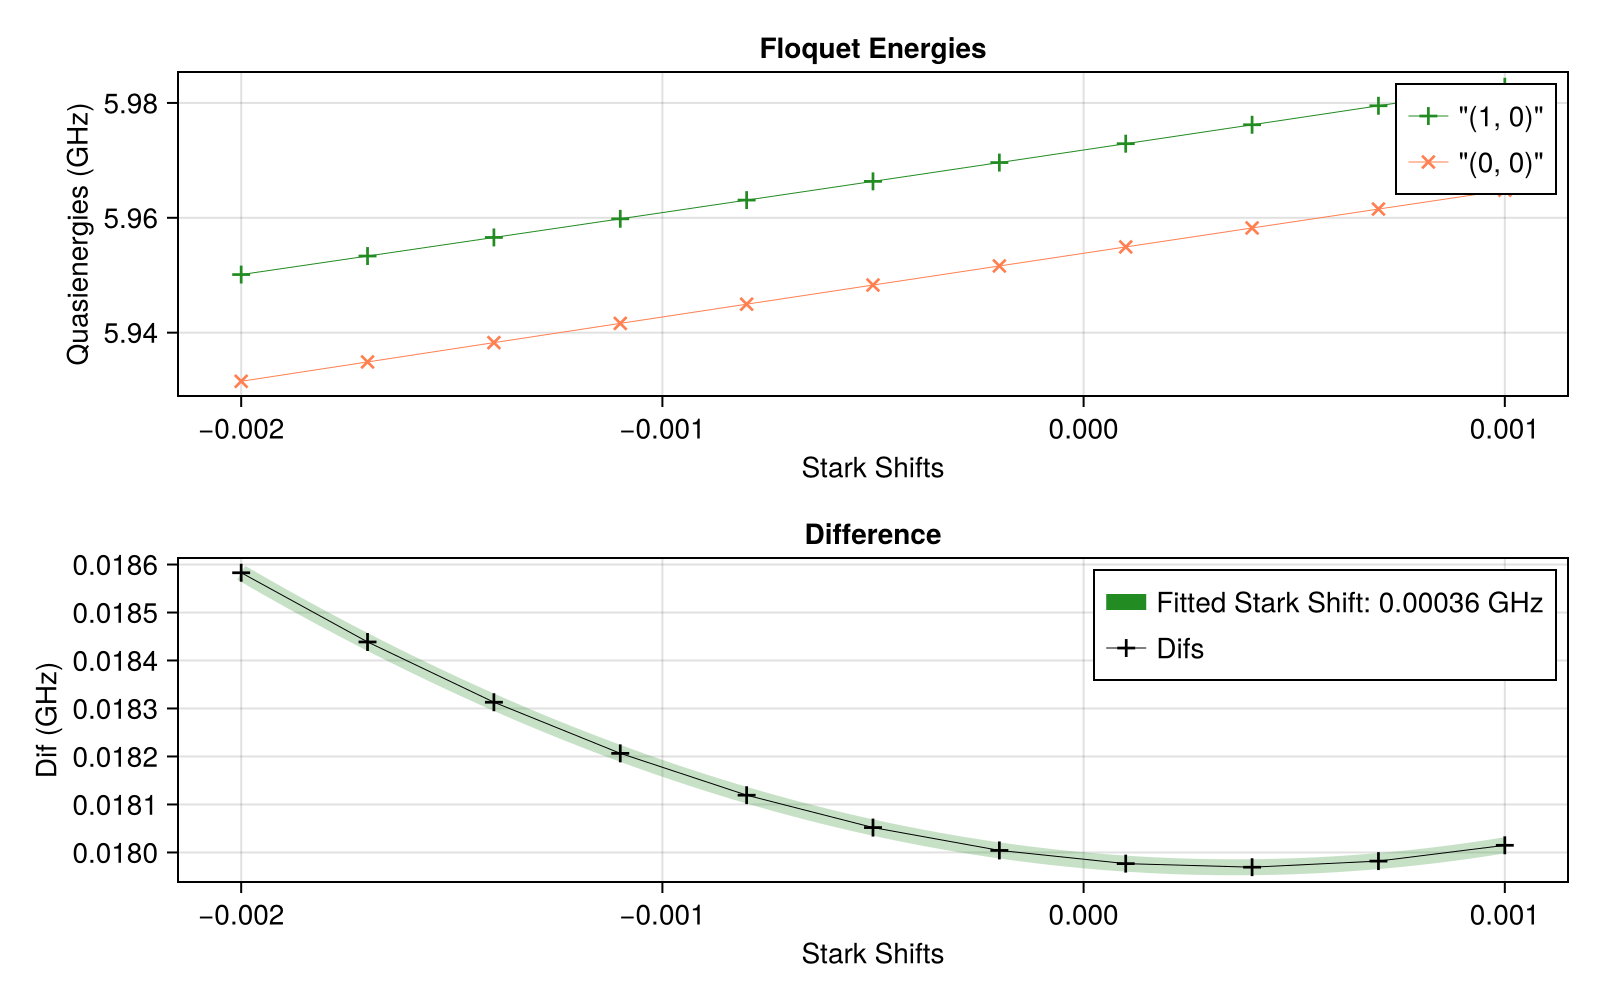

In [12]:
ge_ε = 0.00538
drive_op = Mode6.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode6, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [13]:

ψ1 = Mode6.dressed_states[(1,0)]+Mode6.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode6.dressed_states[(0,0)]+Mode6.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode6.dressed_energies[(1,0)]-Mode6.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode6.dressed_energies[(1,1)]-Mode6.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 15:15:08] Info: On Level 1
[2024-11-10 15:15:08] Info: On Step 1: t = 90.0
[2024-11-10 15:15:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 15:15:12] Info: Time Evolution Complete
[2024-11-10 15:15:12] Info: Done with Level_1_step_1
[2024-11-10 15:15:12] Info: Using Check Op
[2024-11-10 15:15:12] Info: Accurace: 0.997050121741824
[2024-11-10 15:15:12] Info: ------------------------------------------------------------------------------
[2024-11-10 15:15:12] Info: On Step 2: t = 92.5
[2024-11-10 15:15:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:15:14] Info: Time Evolution Complete
[2024-11-10 15:15:14] Info: Done with Level_1_step_2
[2024-11-10 15:15:14] Info: Using Check Op
[2024-11-10 15:15:14] Info: Accurace: 0.9994943996449255
[2024-11-10 15:15:14] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999558
  "freq_d"        => 4.60396

In [14]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999558
  "freq_d"        => 4.60396

In [15]:
ψ = Mode6.dressed_states[(1,0)]+Mode6.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:16:01.142
It is being saved at: Data/
[2024-11-10 15:16:01] Info: Running operator q_ge_1/2
[2024-11-10 15:16:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:16:03] Info: Time Evolution Complete
[2024-11-10 15:16:03] Info: Saving Steps
[2024-11-10 15:16:08] Info: Done with Step_1
[2024-11-10 15:16:08] Info: Done With Running Sequence
[2024-11-10 15:16:08] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [16]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

In [17]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

[2024-11-10 15:16:11] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [18]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.49995828961325567 - 9.656311858608353e-17im
0.4996454861298362 + 1.1609362560702274e-18im


In [19]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997361952062 - 9.529415204689762e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [20]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:16:16] Info: On Level 1
[2024-11-10 15:16:16] Info: On Step 1: t = 90.0
[2024-11-10 15:16:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:16:18] Info: Time Evolution Complete
[2024-11-10 15:16:18] Info: Done with Level_1_step_1
[2024-11-10 15:16:18] Info: Accurace: 0.9969553816639839
[2024-11-10 15:16:18] Info: ------------------------------------------------------------------------------
[2024-11-10 15:16:18] Info: On Step 2: t = 92.5
[2024-11-10 15:16:18] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:16:20] Info: Time Evolution Complete
[2024-11-10 15:16:20] Info: Done with Level_1_step_2
[2024-11-10 15:16:20] Info: Accurace: 0.9994001728460933
[2024-11-10 15:16:20] Info: ------------------------------------------------------------------------------
[2024-11-10 15:16:20] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999463
  "freq_d"        => 4.60404

In [21]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999463
  "freq_d"        => 4.60404

In [22]:
ψ = Mode6.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:17:11.339
It is being saved at: Data/
[2024-11-10 15:17:11] Info: Running operator q_ge_0
[2024-11-10 15:17:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 15:17:15] Info: Time Evolution Complete
[2024-11-10 15:17:15] Info: Saving Steps
[2024-11-10 15:17:15] Info: Done with Step_1
[2024-11-10 15:17:15] Info: Done With Running Sequence
[2024-11-10 15:17:15] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [23]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

In [24]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

[2024-11-10 15:17:15] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [25]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.0002251694214560953 + 3.563726350628175e-21im
0.9997123872913413 - 3.1860368468745884e-17im
6.203740820078661e-5 - 5.315743526323399e-21im


In [26]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997361952062 - 9.529415204689762e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [27]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:17:16] Info: On Level 1
[2024-11-10 15:17:16] Info: On Step 1: t = 90.0
[2024-11-10 15:17:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:17:17] Info: Time Evolution Complete
[2024-11-10 15:17:17] Info: Done with Level_1_step_1
[2024-11-10 15:17:17] Info: Accurace: 0.9971905906284703
[2024-11-10 15:17:17] Info: ------------------------------------------------------------------------------
[2024-11-10 15:17:17] Info: On Step 2: t = 92.5
[2024-11-10 15:17:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:17:20] Info: Time Evolution Complete
[2024-11-10 15:17:20] Info: Done with Level_1_step_2
[2024-11-10 15:17:20] Info: Accurace: 0.9996440570769066
[2024-11-10 15:17:20] Info: ------------------------------------------------------------------------------
[2024-11-10 15:17:20] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999708
  "freq_d"        => 4.60389

In [28]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999708
  "freq_d"        => 4.60389

In [29]:
ψ = Mode6.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:18:06.743
It is being saved at: Data/
[2024-11-10 15:18:06] Info: Running operator q_ge_1
[2024-11-10 15:18:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:18:08] Info: Time Evolution Complete
[2024-11-10 15:18:08] Info: Saving Steps
[2024-11-10 15:18:09] Info: Done with Step_1
[2024-11-10 15:18:09] Info: Done With Running Sequence
[2024-11-10 15:18:09] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [30]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

In [31]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

[2024-11-10 15:18:09] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [32]:
EVs[(1,1)][end]

0.9997106707726603 - 7.817957198573212e-18im

In [33]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999977828193735 - 7.953075295886778e-18im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [34]:

ψ1 = Mode6.dressed_states[(0,0)]+(Mode6.dressed_states[(1,1)]+Mode6.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode6.dressed_states[(1,0)]+(Mode6.dressed_states[(0,1)]+Mode6.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode6.dressed_energies[(1,0)]-Mode6.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode6.dressed_energies[(1,1)]-Mode6.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode6.dressed_energies[(1,3)]-Mode6.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 15:18:10] Info: On Level 1
[2024-11-10 15:18:10] Info: On Step 1: t = 90.0
[2024-11-10 15:18:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:18:11] Info: Time Evolution Complete
[2024-11-10 15:18:11] Info: Done with Level_1_step_1
[2024-11-10 15:18:11] Info: Using Check Op
[2024-11-10 15:18:11] Info: Accurace: 0.9966177915287722
[2024-11-10 15:18:11] Info: ------------------------------------------------------------------------------
[2024-11-10 15:18:11] Info: On Step 2: t = 92.5
[2024-11-10 15:18:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:18:13] Info: Time Evolution Complete
[2024-11-10 15:18:13] Info: Done with Level_1_step_2
[2024-11-10 15:18:13] Info: Using Check Op
[2024-11-10 15:18:13] Info: Accurace: 0.9990370226697483
[2024-11-10 15:18:13] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999094
  "freq_d"        => 4.60384

In [35]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999094
  "freq_d"        => 4.60384

In [36]:
ψ = Mode6.dressed_states[(1,1)]+(Mode6.dressed_states[(0,0)]+Mode6.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:19:01.893
It is being saved at: Data/
[2024-11-10 15:19:01] Info: Running operator q_ge_4/3
[2024-11-10 15:19:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:19:04] Info: Time Evolution Complete
[2024-11-10 15:19:04] Info: Saving Steps
[2024-11-10 15:19:05] Info: Done with Step_1
[2024-11-10 15:19:05] Info: Done With Running Sequence
[2024-11-10 15:19:05] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [37]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

In [38]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

[2024-11-10 15:19:05] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [39]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49993655822649014 + 1.7534795015434592e-17im
0.24994296573996672 + 1.088190148887484e-17im
0.2493653654843207 + 1.7156644271577264e-17im


In [40]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998240838156 + 4.557601762796697e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [41]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:19:06] Info: On Level 1
[2024-11-10 15:19:06] Info: On Step 1: t = 90.0
[2024-11-10 15:19:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:19:07] Info: Time Evolution Complete
[2024-11-10 15:19:07] Info: Done with Level_1_step_1
[2024-11-10 15:19:07] Info: Accurace: 0.9971920674140092
[2024-11-10 15:19:07] Info: ------------------------------------------------------------------------------
[2024-11-10 15:19:07] Info: On Step 2: t = 92.5
[2024-11-10 15:19:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:19:09] Info: Time Evolution Complete
[2024-11-10 15:19:09] Info: Done with Level_1_step_2
[2024-11-10 15:19:09] Info: Accurace: 0.9996482938838706
[2024-11-10 15:19:09] Info: ------------------------------------------------------------------------------
[2024-11-10 15:19:09] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60374

In [42]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60374

In [43]:
ψ = Mode6.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:20:00.285
It is being saved at: Data/
[2024-11-10 15:20:00] Info: Running operator q_ge_2
[2024-11-10 15:20:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:20:02] Info: Time Evolution Complete
[2024-11-10 15:20:02] Info: Saving Steps
[2024-11-10 15:20:03] Info: Done with Step_1
[2024-11-10 15:20:03] Info: Done With Running Sequence
[2024-11-10 15:20:03] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [44]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

In [45]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge2_res["times"], EVs, plot_every = 10)

[2024-11-10 15:20:03] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [46]:
EVs[(1,2)][end]

0.9997129457629423 - 4.7203172587223306e-17im

In [47]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999782353383 - 4.761780638195625e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [48]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:20:04] Info: On Level 1
[2024-11-10 15:20:04] Info: On Step 1: t = 90.0
[2024-11-10 15:20:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:20:05] Info: Time Evolution Complete
[2024-11-10 15:20:05] Info: Done with Level_1_step_1
[2024-11-10 15:20:05] Info: Accurace: 0.9971887538024959
[2024-11-10 15:20:05] Info: ------------------------------------------------------------------------------
[2024-11-10 15:20:05] Info: On Step 2: t = 92.5
[2024-11-10 15:20:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:20:07] Info: Time Evolution Complete
[2024-11-10 15:20:07] Info: Done with Level_1_step_2
[2024-11-10 15:20:07] Info: Accurace: 0.9996477987824638
[2024-11-10 15:20:07] Info: ------------------------------------------------------------------------------
[2024-11-10 15:20:07] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [49]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60359

In [50]:
ψ = Mode6.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:20:58.869
It is being saved at: Data/
[2024-11-10 15:20:58] Info: Running operator q_ge_3
[2024-11-10 15:20:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:21:01] Info: Time Evolution Complete
[2024-11-10 15:21:01] Info: Saving Steps
[2024-11-10 15:21:01] Info: Done with Step_1
[2024-11-10 15:21:01] Info: Done With Running Sequence
[2024-11-10 15:21:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [51]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-10 15:21:01] Info: Making Plot


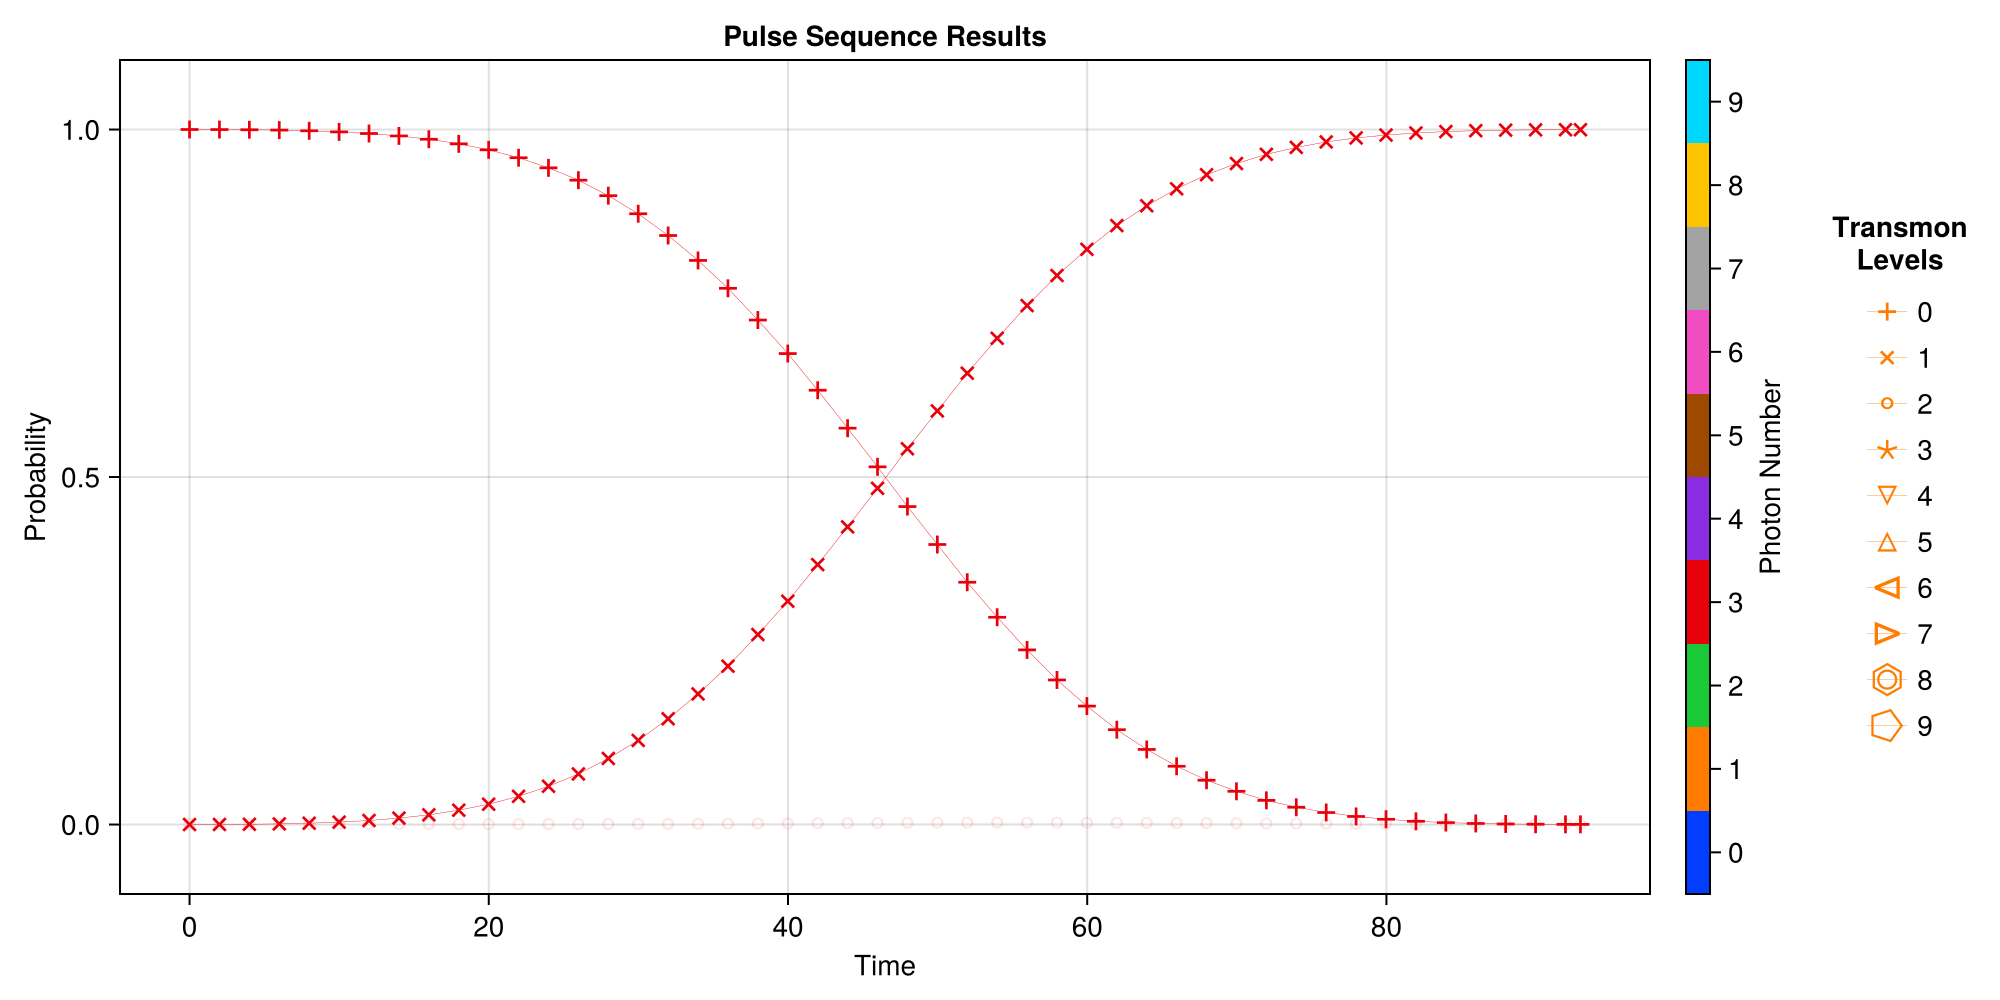

CairoMakie.Screen{IMAGE}


In [52]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [53]:
EVs[(1,3)][end]

0.9997130270266689 - 4.319830341649044e-17im

In [54]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999970689304 - 4.3036829496679603e-17im

### Guassian e -> f

In [55]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-10 15:21:02] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-10 15:21:07] Info: Done With Floquet Sweep
[2024-11-10 15:21:07] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016523379067948614	 0.008957143000641755	 2.0062820967812436
Stark shift res: [0.00016523379067948614, 55.64658210937459]


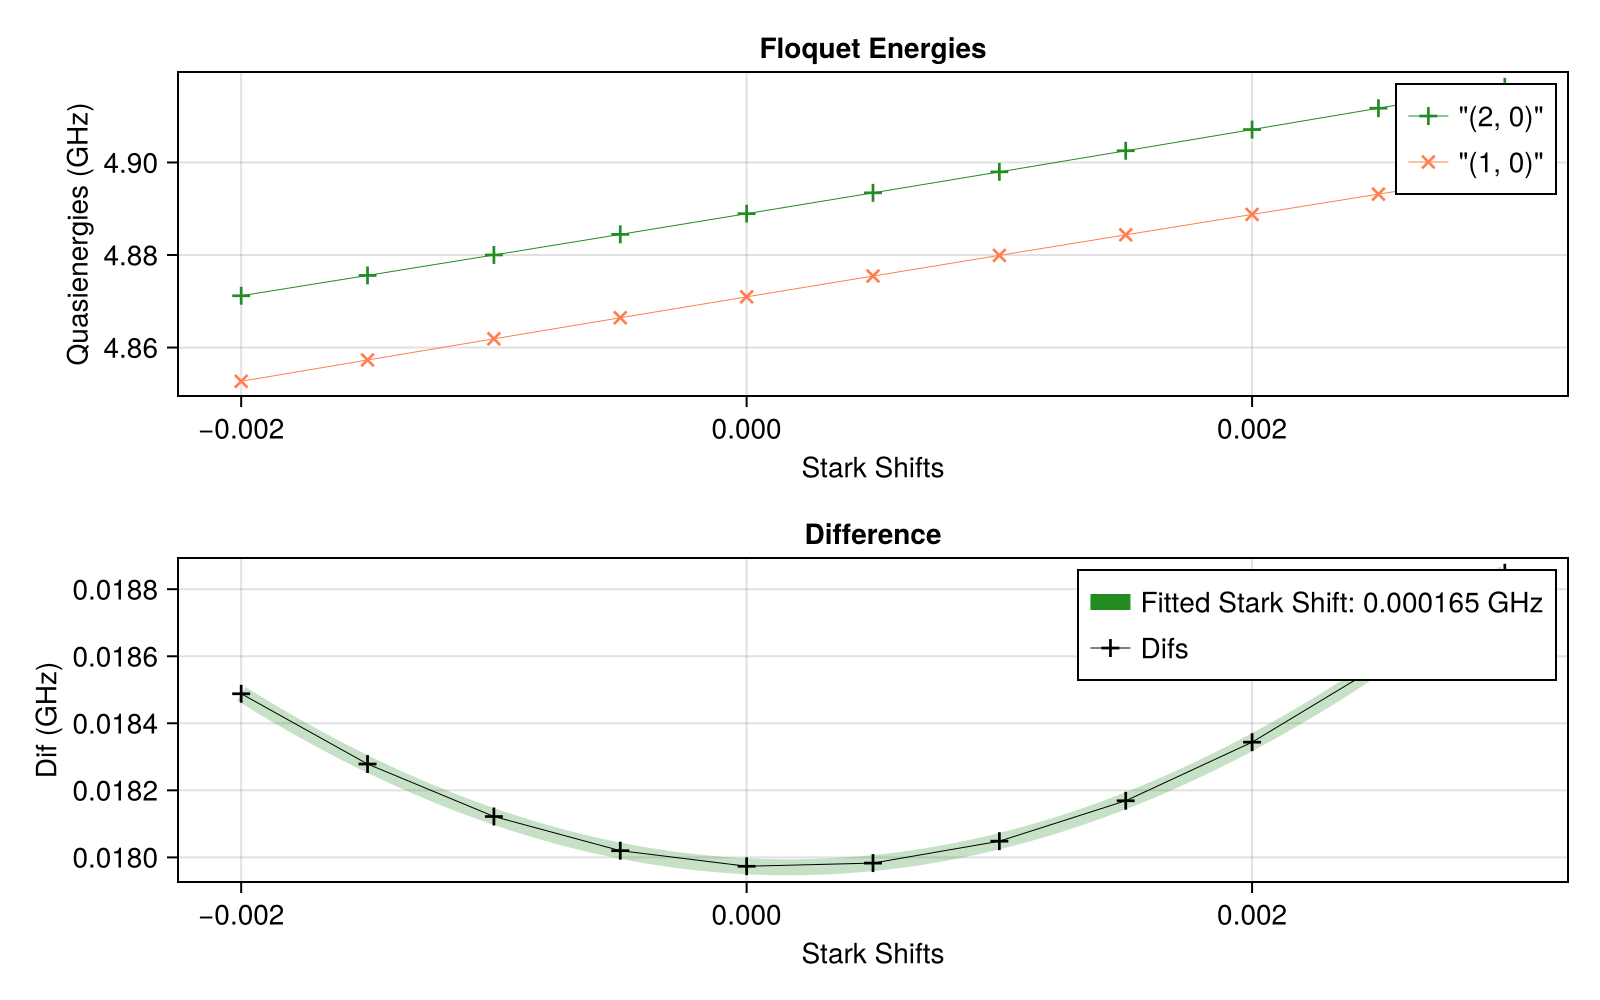

In [56]:
ef_ε = 0.00385
drive_op = Mode6.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode6, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [57]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:21:07] Info: On Level 1
[2024-11-10 15:21:07] Info: On Step 1: t = 90.0
[2024-11-10 15:21:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:21:08] Info: Time Evolution Complete
[2024-11-10 15:21:08] Info: Done with Level_1_step_1
[2024-11-10 15:21:08] Info: Accurace: 0.997348571524197
[2024-11-10 15:21:08] Info: ------------------------------------------------------------------------------
[2024-11-10 15:21:08] Info: On Step 2: t = 92.5
[2024-11-10 15:21:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:21:11] Info: Time Evolution Complete
[2024-11-10 15:21:11] Info: Done with Level_1_step_2
[2024-11-10 15:21:11] Info: Accurace: 0.9998118544263301
[2024-11-10 15:21:11] Info: ------------------------------------------------------------------------------
[2024-11-10 15:21:11] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999874
  "freq_d"        => 4.49556

In [58]:
#Mode6.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999874
  "freq_d"        => 4.49556

In [59]:
ψ = Mode6.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:22:03.902
It is being saved at: Data/
[2024-11-10 15:22:03] Info: Running operator q_ef_0
[2024-11-10 15:22:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:22:06] Info: Time Evolution Complete
[2024-11-10 15:22:06] Info: Saving Steps
[2024-11-10 15:22:07] Info: Done with Step_1
[2024-11-10 15:22:07] Info: Done With Running Sequence
[2024-11-10 15:22:07] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [60]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-10 15:22:07] Info: Making Plot


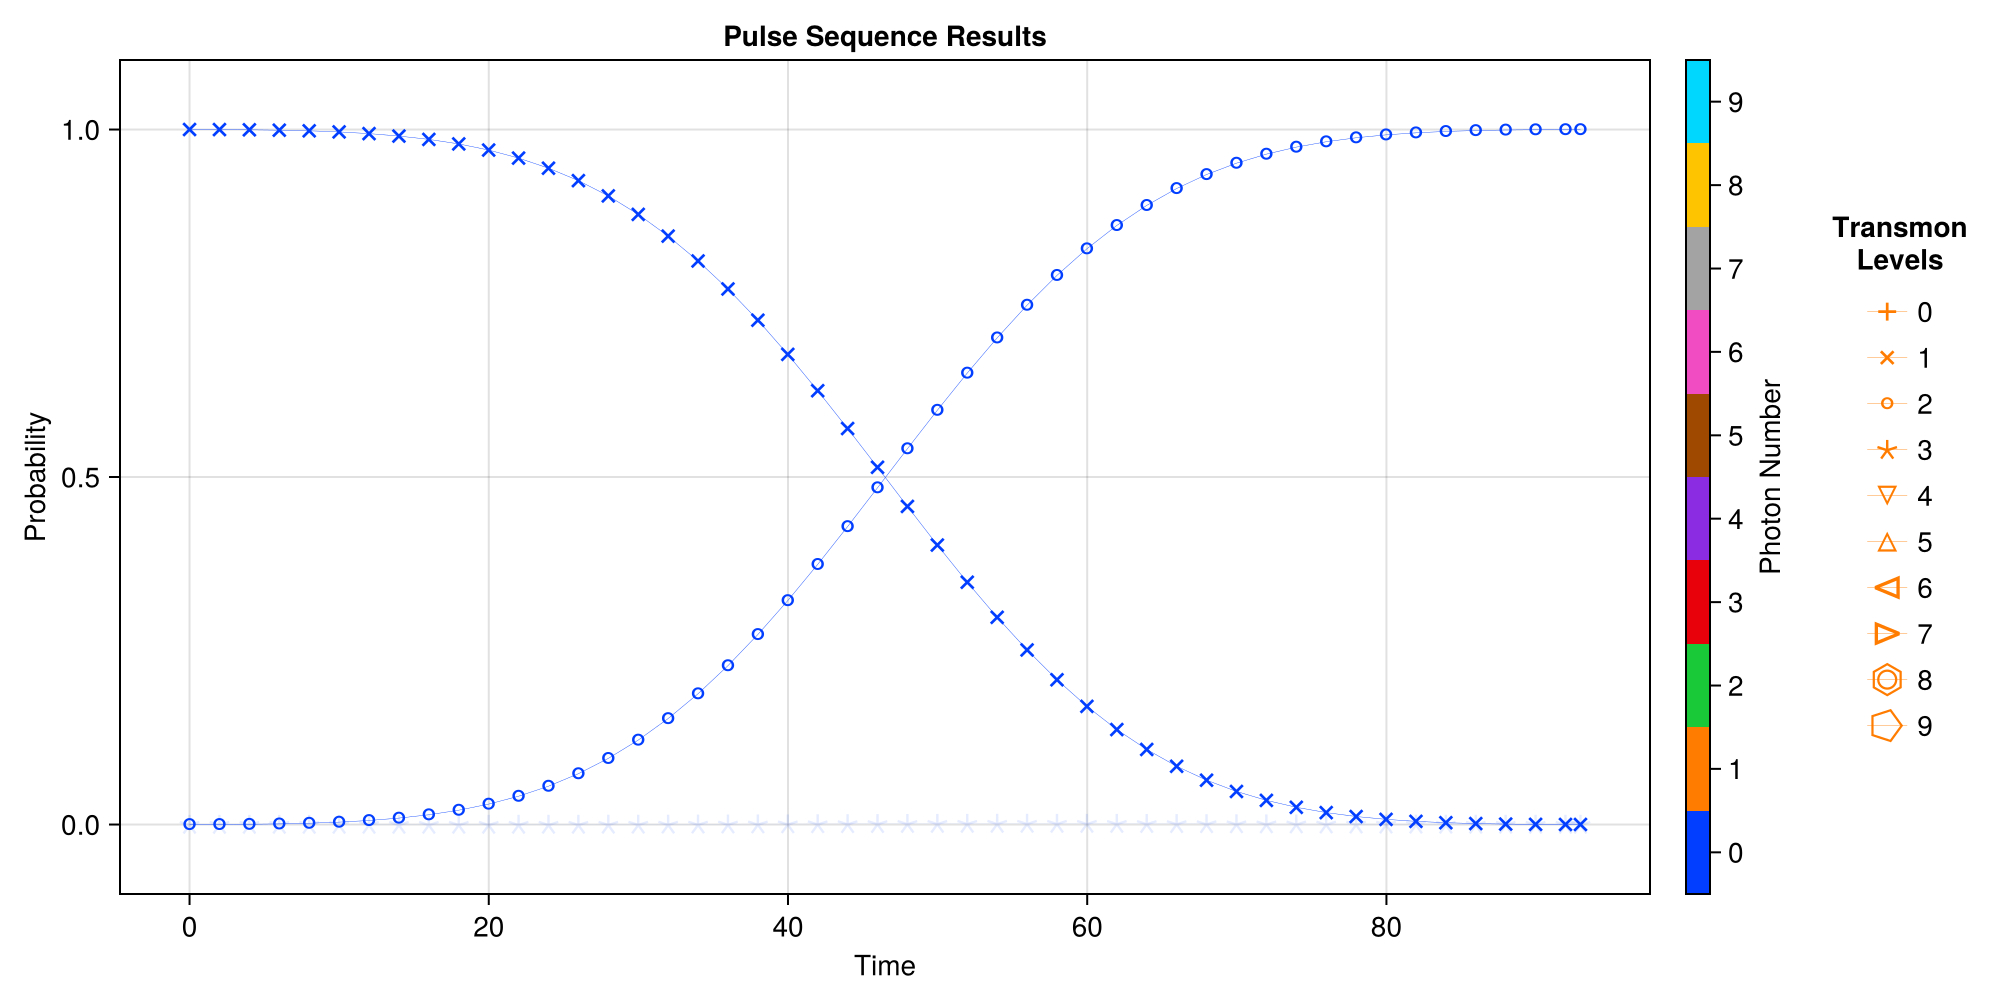

CairoMakie.Screen{IMAGE}


In [61]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [62]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5783367991004125e-5 - 2.87874514770177e-22im
4.684343138403385e-5 - 2.4009182244164495e-21im
0.9998917773848744 - 3.5892148418607765e-17im
4.287779468760544e-5 + 2.1334623471063943e-22im


In [63]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972822454272 - 3.576127445181574e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [64]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:22:07] Info: On Level 1
[2024-11-10 15:22:07] Info: On Step 1: t = 90.0
[2024-11-10 15:22:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:22:09] Info: Time Evolution Complete
[2024-11-10 15:22:09] Info: Done with Level_1_step_1
[2024-11-10 15:22:09] Info: Accurace: 0.9973657597783159
[2024-11-10 15:22:09] Info: ------------------------------------------------------------------------------
[2024-11-10 15:22:09] Info: On Step 2: t = 92.5
[2024-11-10 15:22:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:22:11] Info: Time Evolution Complete
[2024-11-10 15:22:11] Info: Done with Level_1_step_2
[2024-11-10 15:22:11] Info: Accurace: 0.9998312110080201
[2024-11-10 15:22:11] Info: ------------------------------------------------------------------------------
[2024-11-10 15:22:11] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49542

In [65]:
#Mode6.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49542

In [66]:
ψ = Mode6.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:23:02.232
It is being saved at: Data/
[2024-11-10 15:23:02] Info: Running operator q_ef_1
[2024-11-10 15:23:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:23:04] Info: Time Evolution Complete
[2024-11-10 15:23:04] Info: Saving Steps
[2024-11-10 15:23:05] Info: Done with Step_1
[2024-11-10 15:23:05] Info: Done With Running Sequence
[2024-11-10 15:23:05] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [67]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-10 15:23:05] Info: Making Plot


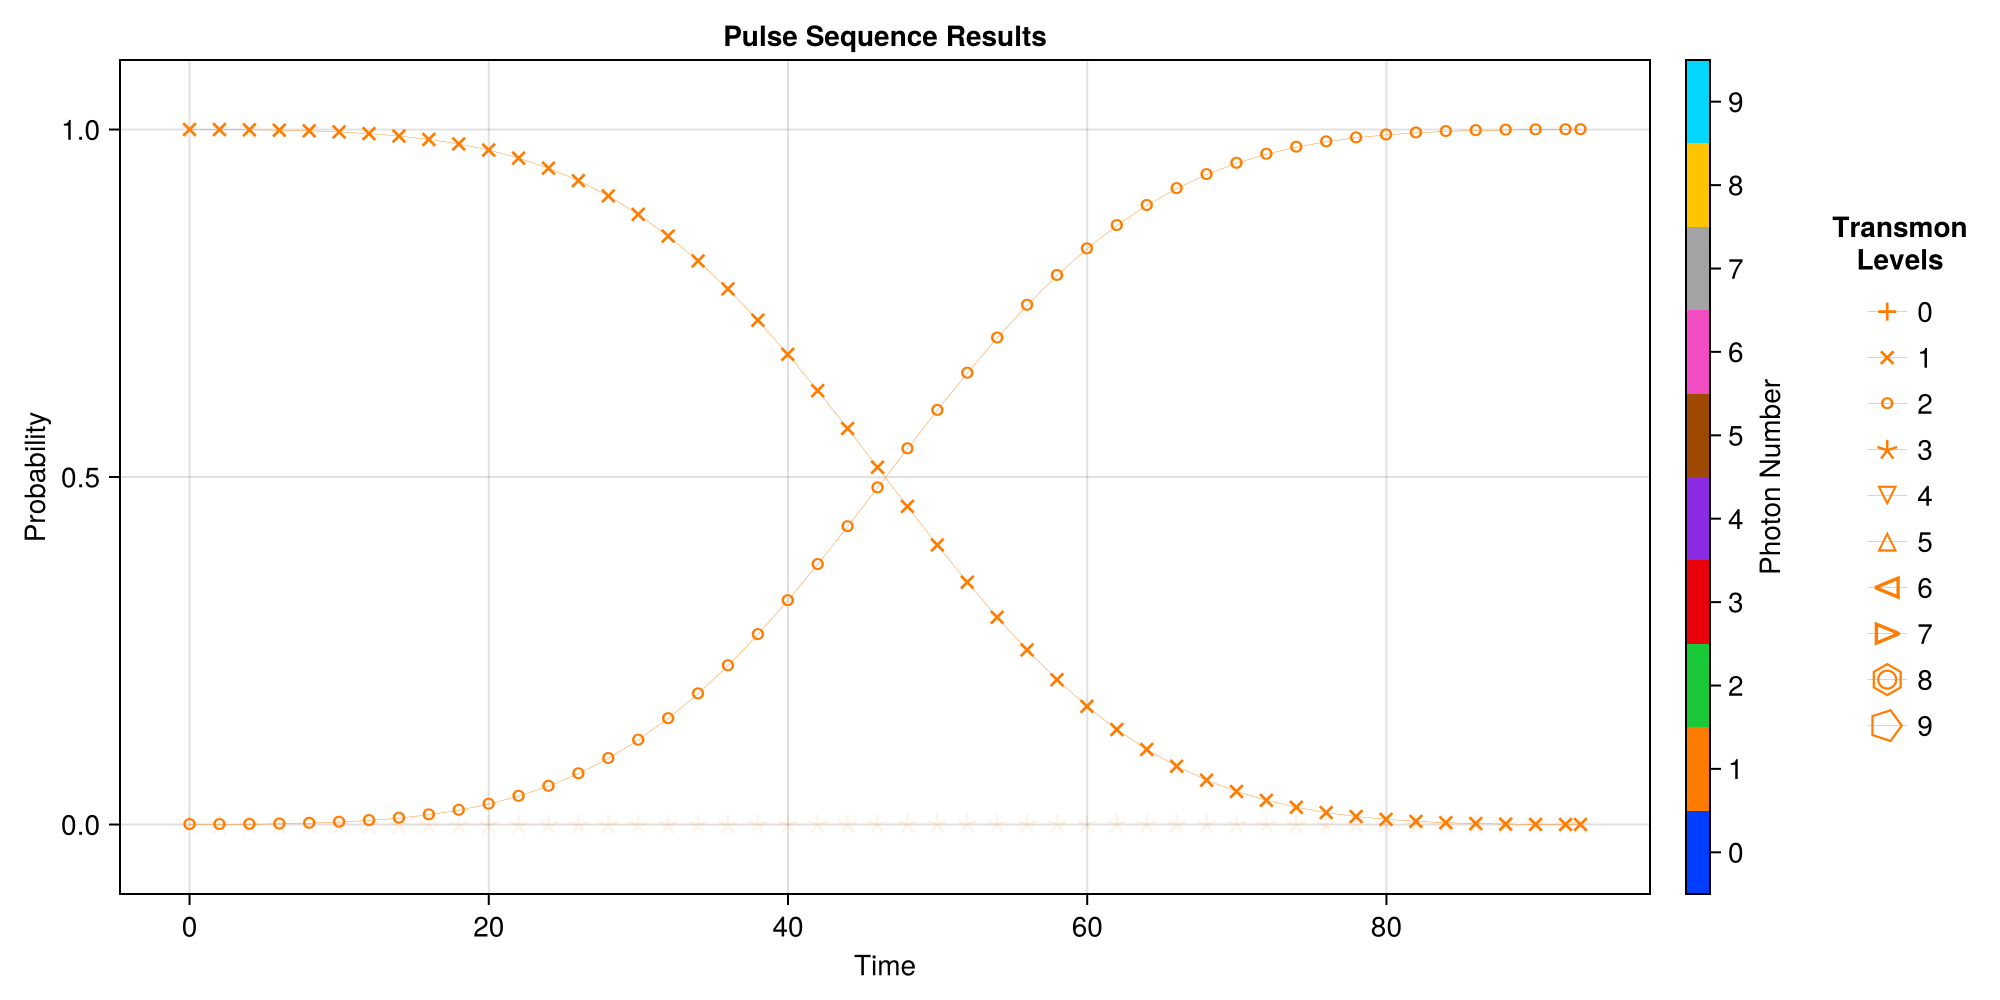

CairoMakie.Screen{IMAGE}


In [68]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [69]:
EVs[(2,1)][end]

0.9998943611946156 + 3.159877705362374e-17im

In [70]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998403378051 + 3.1371291905259355e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [71]:
ψ1 = Mode6.dressed_states[(1,0)]/sqrt(2)+Mode6.dressed_states[(2,0)]+Mode6.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode6.dressed_states[(2,0)]+(Mode6.dressed_states[(1,0)]+Mode6.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode6.dressed_energies[(2,0)]-Mode6.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode6.dressed_energies[(2,1)]-Mode6.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode6.dressed_energies[(2,3)]-Mode6.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-10 15:23:05] Info: On Level 1
[2024-11-10 15:23:05] Info: On Step 1: t = 90.0
[2024-11-10 15:23:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:23:07] Info: Time Evolution Complete
[2024-11-10 15:23:07] Info: Done with Level_1_step_1
[2024-11-10 15:23:07] Info: Using Check Op
[2024-11-10 15:23:07] Info: Accurace: 0.9990318434502679
[2024-11-10 15:23:07] Info: ------------------------------------------------------------------------------
[2024-11-10 15:23:07] Info: On Step 2: t = 92.5
[2024-11-10 15:23:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:23:09] Info: Time Evolution Complete
[2024-11-10 15:23:09] Info: Done with Level_1_step_2
[2024-11-10 15:23:09] Info: Using Check Op
[2024-11-10 15:23:09] Info: Accurace: 0.9995672133656801
[2024-11-10 15:23:09] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999576
  "freq_d"        => 4.49535

In [72]:
#Mode6.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999576
  "freq_d"        => 4.49535

In [73]:
ψ = Mode6.dressed_states[(1,0)]/sqrt(2)+Mode6.dressed_states[(2,0)]+Mode6.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:24:01.287
It is being saved at: Data/
[2024-11-10 15:24:01] Info: Running operator q_ef_3/2
[2024-11-10 15:24:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 15:24:04] Info: Time Evolution Complete
[2024-11-10 15:24:04] Info: Saving Steps
[2024-11-10 15:24:04] Info: Done with Step_1
[2024-11-10 15:24:04] Info: Done With Running Sequence
[2024-11-10 15:24:04] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [74]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-10 15:24:05] Info: Making Plot


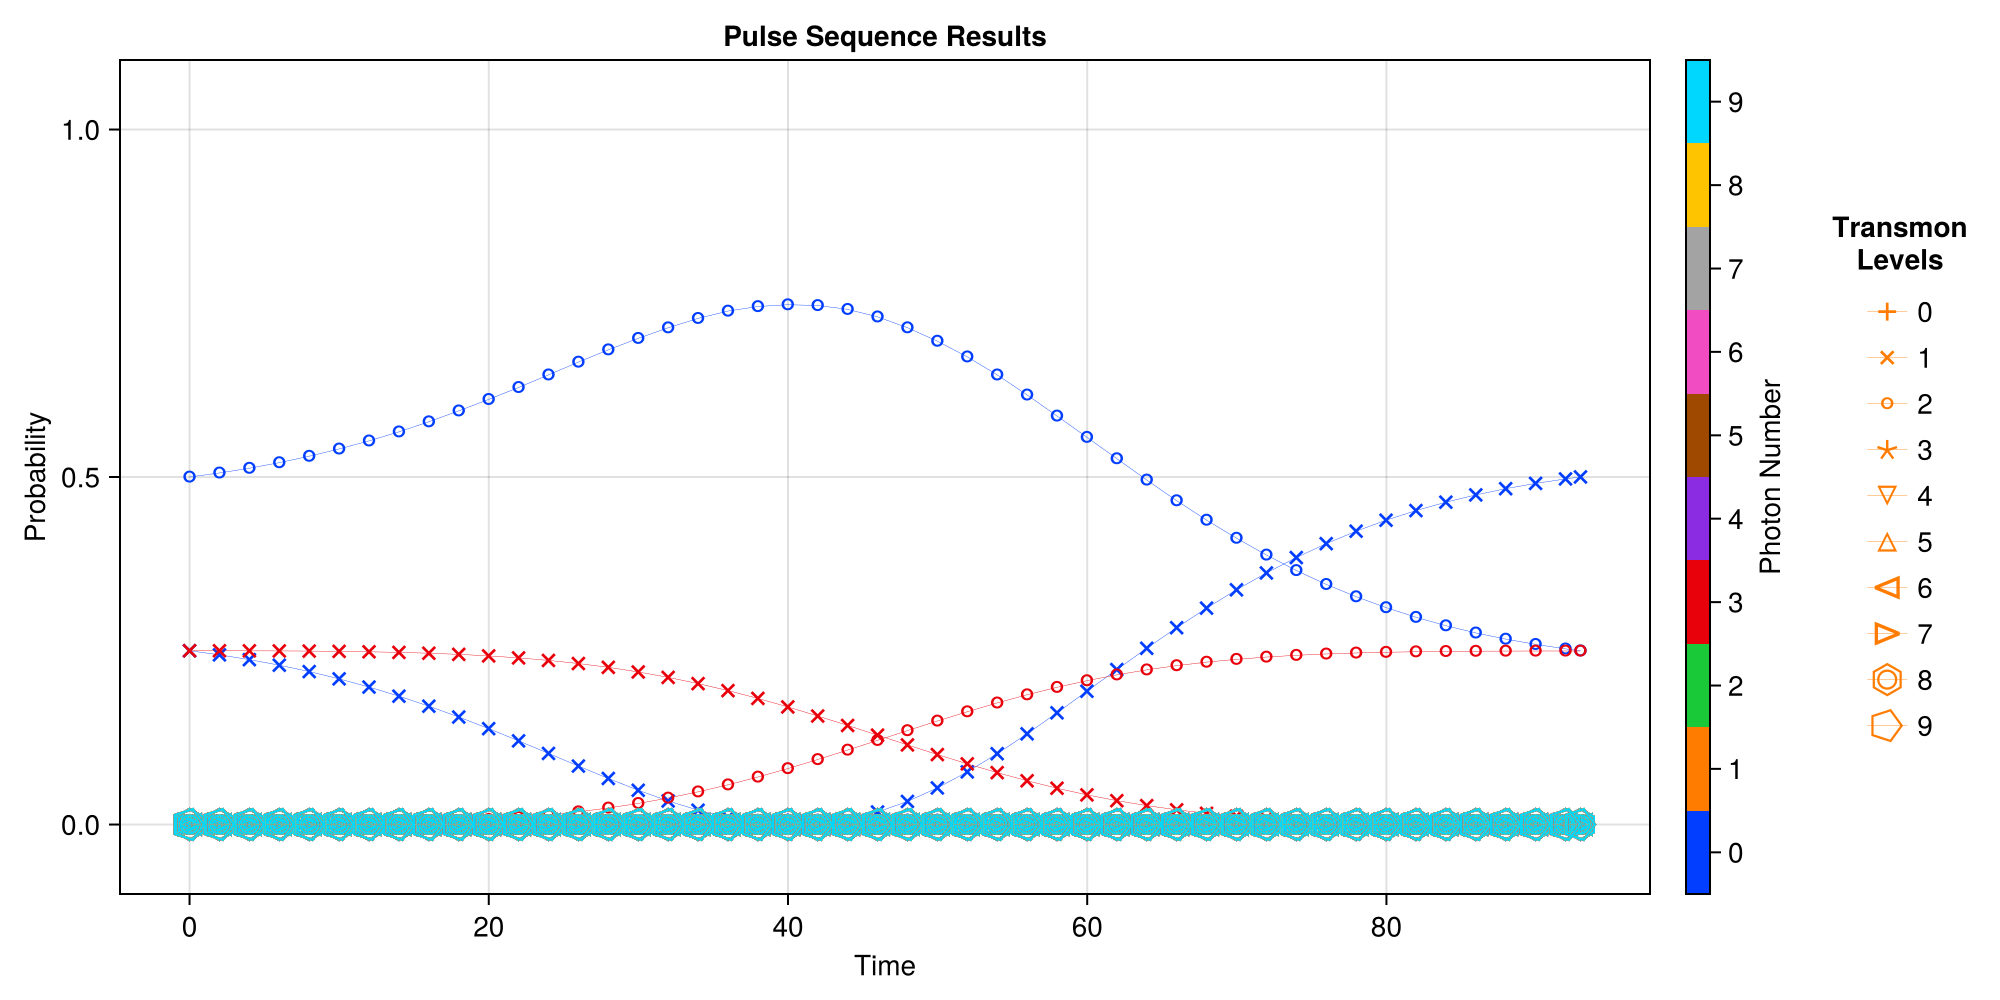

CairoMakie.Screen{IMAGE}


In [75]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [76]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24983576075184621 + 2.0138877543787343e-17im
0.5000808327216484 - 6.980815850440882e-17im
0.24966537692151686 - 1.429251975504452e-17im


In [77]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998247561755 - 6.397019760870203e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [78]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-10 15:24:05] Info: On Level 1
[2024-11-10 15:24:05] Info: On Step 1: t = 90.0
[2024-11-10 15:24:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:24:08] Info: Time Evolution Complete
[2024-11-10 15:24:08] Info: Done with Level_1_step_1
[2024-11-10 15:24:08] Info: Accurace: 0.9973638460807418
[2024-11-10 15:24:08] Info: ------------------------------------------------------------------------------
[2024-11-10 15:24:08] Info: On Step 2: t = 92.5
[2024-11-10 15:24:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:24:10] Info: Time Evolution Complete
[2024-11-10 15:24:10] Info: Done with Level_1_step_2
[2024-11-10 15:24:10] Info: Accurace: 0.9998309205348649
[2024-11-10 15:24:10] Info: ------------------------------------------------------------------------------
[2024-11-10 15:24:10] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49528

In [79]:
#Mode6.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49528

In [80]:
ψ = Mode6.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:25:24.069
It is being saved at: Data/
[2024-11-10 15:25:24] Info: Running operator q_ef_2
[2024-11-10 15:25:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:25:26] Info: Time Evolution Complete
[2024-11-10 15:25:26] Info: Saving Steps
[2024-11-10 15:25:26] Info: Done with Step_1
[2024-11-10 15:25:26] Info: Done With Running Sequence
[2024-11-10 15:25:26] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [81]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

In [82]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

[2024-11-10 15:25:27] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [83]:
EVs[(2,2)][end]

0.9998945425141357 - 3.4781930727875855e-17im

In [84]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.99999999578839 - 3.3952415302578637e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [85]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode6.dressed_states[state1]
ψ2 = Mode6.dressed_states[state2]

freq_d = Mode6.dressed_energies[state2]-Mode6.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 15:25:27] Info: On Level 1
[2024-11-10 15:25:27] Info: On Step 1: t = 90.0
[2024-11-10 15:25:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:25:29] Info: Time Evolution Complete
[2024-11-10 15:25:29] Info: Done with Level_1_step_1
[2024-11-10 15:25:29] Info: Accurace: 0.9973618544422381
[2024-11-10 15:25:29] Info: ------------------------------------------------------------------------------
[2024-11-10 15:25:29] Info: On Step 2: t = 95.0
[2024-11-10 15:25:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:25:31] Info: Time Evolution Complete
[2024-11-10 15:25:31] Info: Done with Level_1_step_2
[2024-11-10 15:25:31] Info: Accurace: 0.9987289013901337
[2024-11-10 15:25:31] Info: ------------------------------------------------------------------------------
[2024-11-10 15:25:31] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49514

In [86]:
#Mode6.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49514

In [87]:
ψ = Mode6.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T15:26:23.650
It is being saved at: Data/
[2024-11-10 15:26:23] Info: Running operator q_ef_3
[2024-11-10 15:26:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:26:26] Info: Time Evolution Complete
[2024-11-10 15:26:26] Info: Saving Steps
[2024-11-10 15:26:26] Info: Done with Step_1
[2024-11-10 15:26:26] Info: Done With Running Sequence
[2024-11-10 15:26:26] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [88]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-10 15:26:26] Info: Making Plot


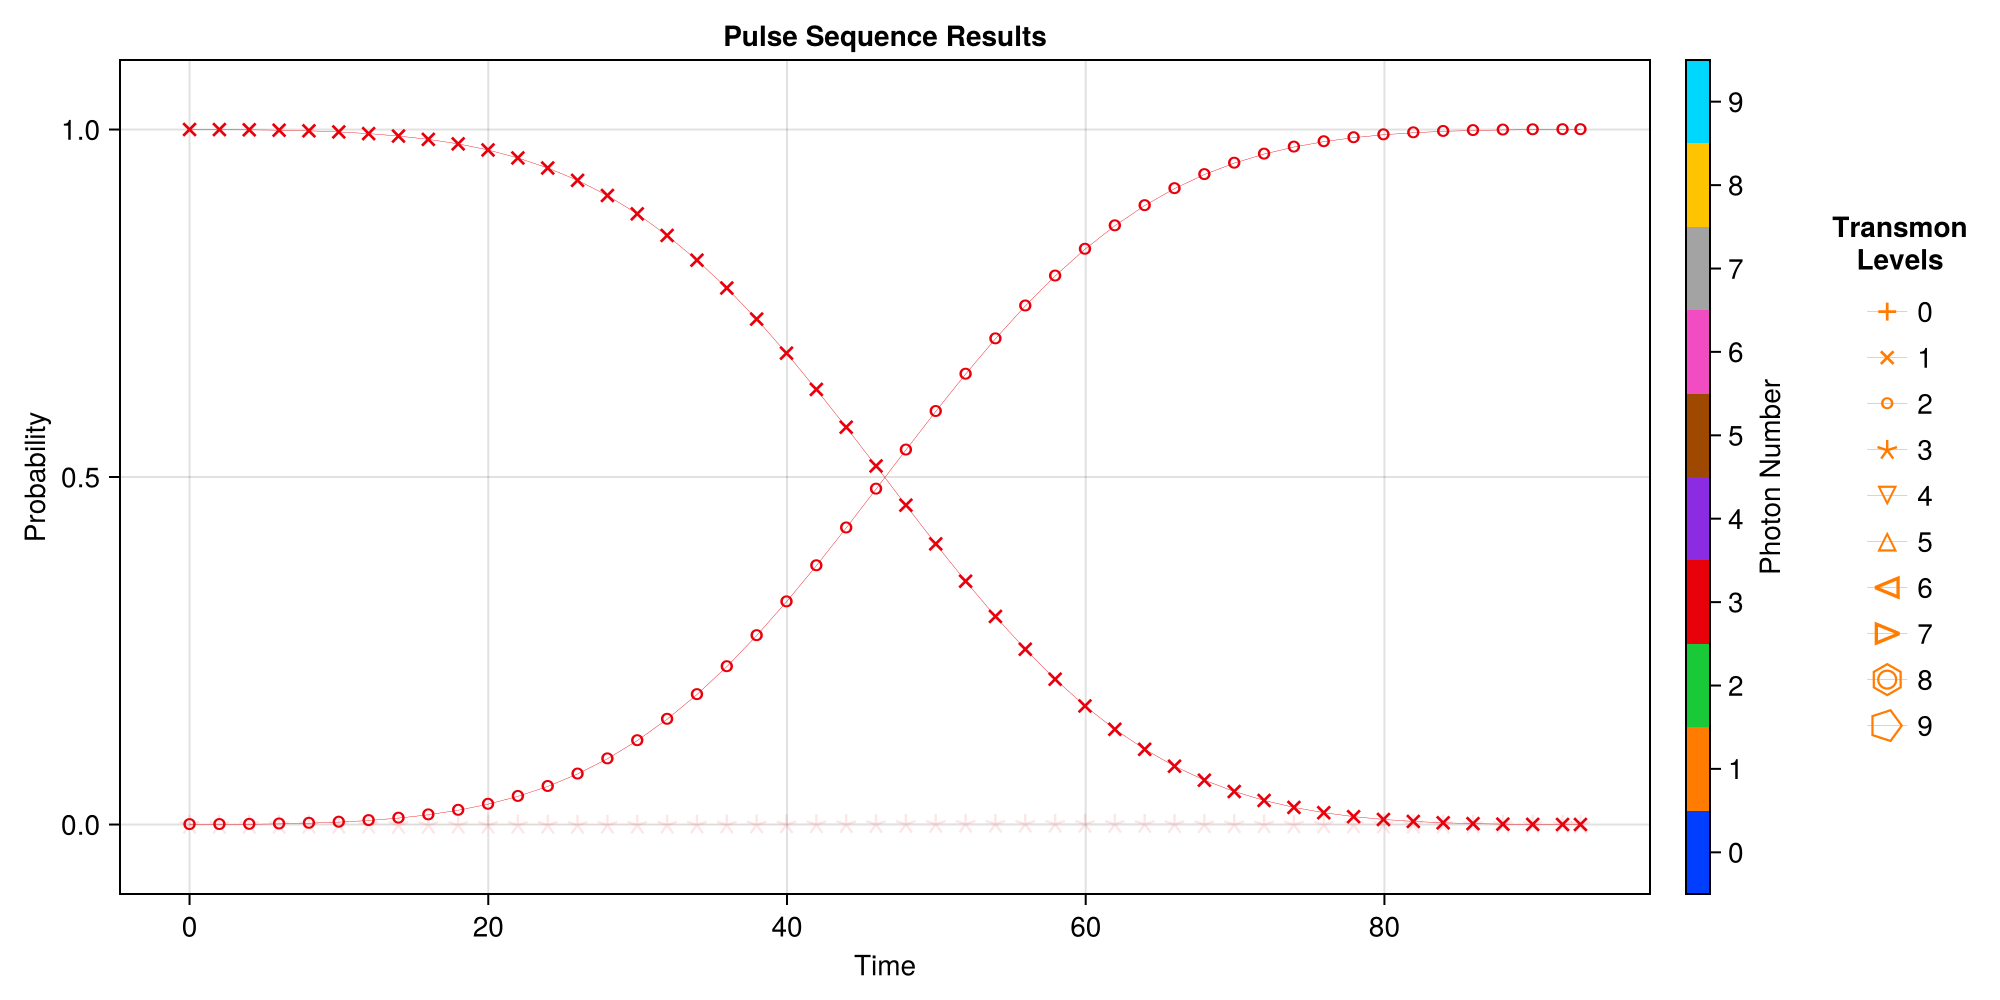

CairoMakie.Screen{IMAGE}


In [89]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [90]:
EVs[(2, 3)][end]

0.9998884664246991 + 9.670450838967993e-19im

In [91]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999874627 + 9.70253022640826e-19im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [92]:
starting_args = deepcopy(Mode6.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode6.dressed_states[(0,0)]
ψ2 = Mode6.dressed_states[(0,0)] + Mode6.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode6.dressed_states[(0,0)]*Mode6.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-10 15:26:27] Info: On Level 1
[2024-11-10 15:26:27] Info: On Step 1: t = 92.96875
[2024-11-10 15:26:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 15:26:29] Info: Time Evolution Complete
[2024-11-10 15:26:29] Info: Done with Level_1_step_1
[2024-11-10 15:26:29] Info: Using Check Op
[2024-11-10 15:26:29] Info: Accurace: 0.9996791521349826
[2024-11-10 15:26:29] Info: ------------------------------------------------------------------------------
[2024-11-10 15:26:29] Info: Highest Accuracy: 0.9996791521349826
[2024-11-10 15:26:29] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-10 15:26:29] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999679
  "freq_d"        => 4.60404

In [93]:
#Mode6.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999679
  "freq_d"        => 4.60404

In [94]:
ψ = Mode6.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-10T15:26:29.598
It is being saved at: Data/
[2024-11-10 15:26:29] Info: Running operator q_half_ge0
[2024-11-10 15:26:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 15:26:31] Info: Time Evolution Complete
[2024-11-10 15:26:31] Info: Saving Steps
[2024-11-10 15:26:31] Info: Done with Step_1
[2024-11-10 15:26:31] Info: Done With Running Sequence
[2024-11-10 15:26:31] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [95]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-10 15:26:32] Info: Making Plot


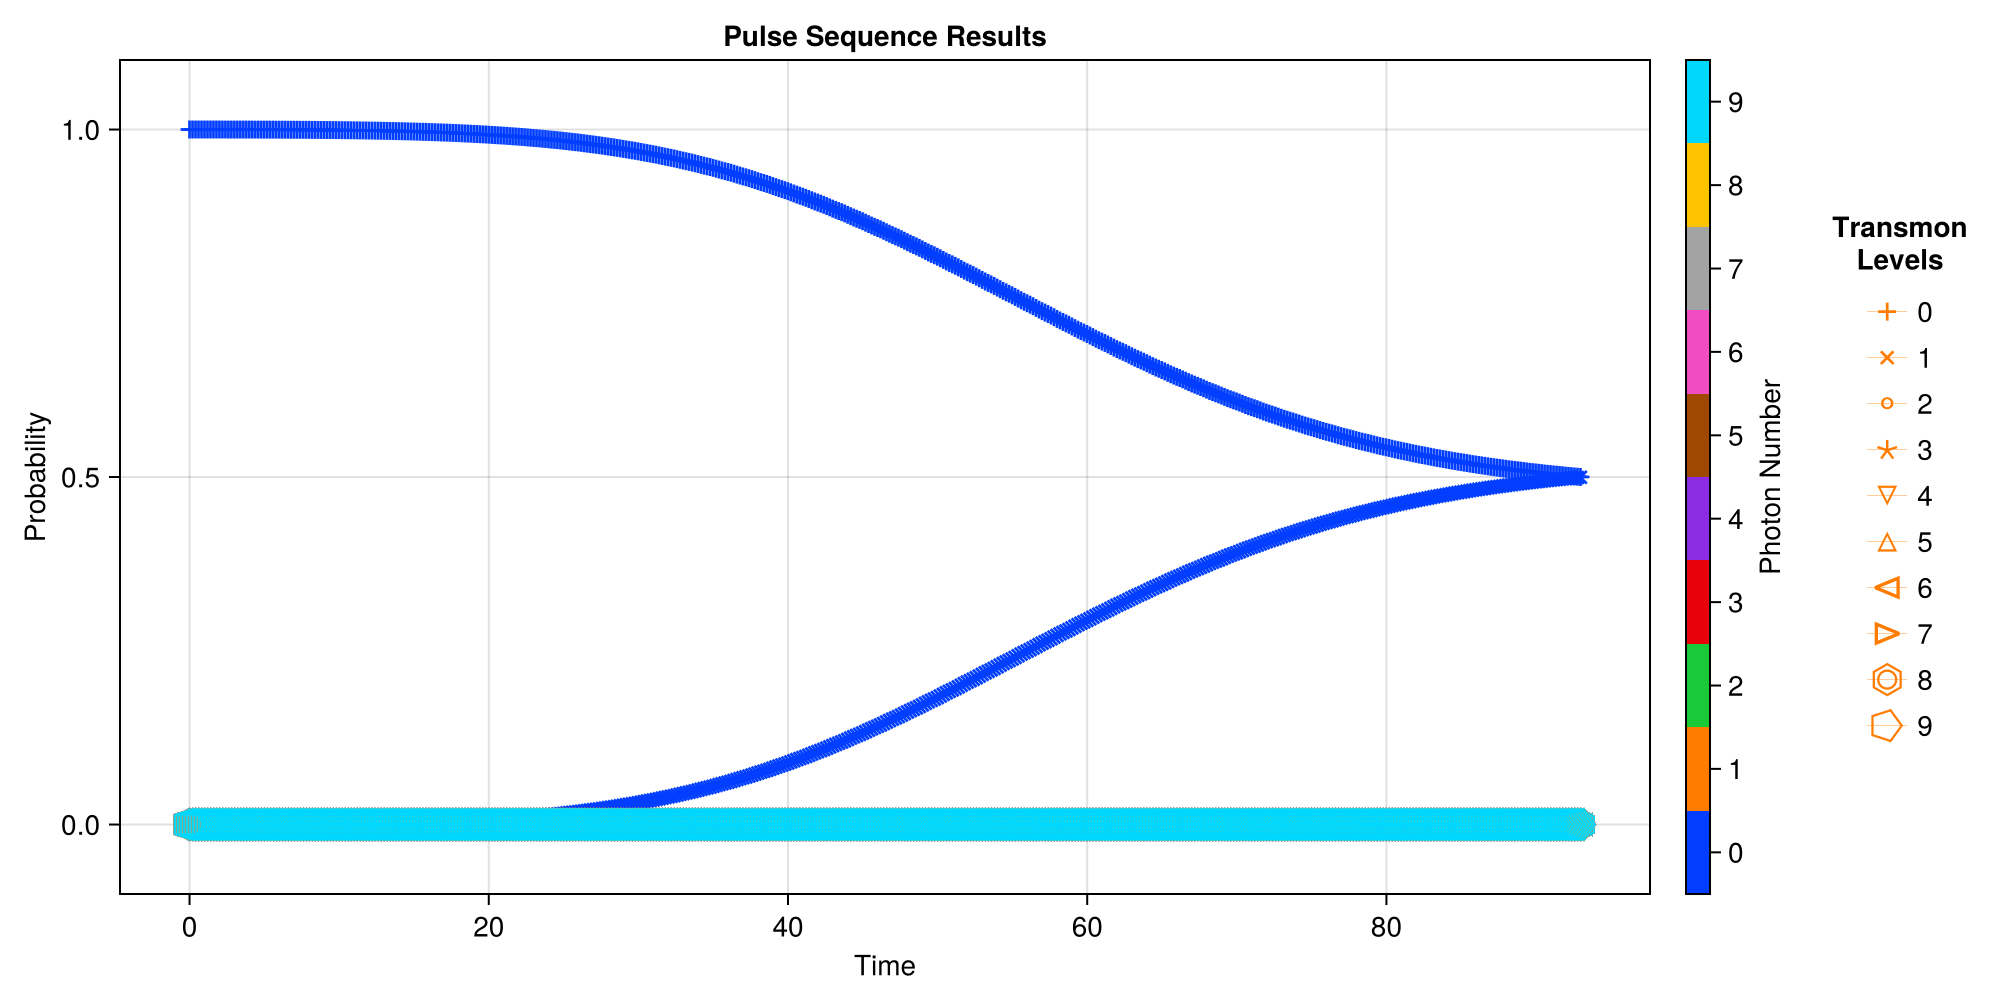

In [96]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, res_half_ge0["times"], EVs_Dict);

In [97]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5000660179635287 + 1.1664463595612821e-17im
0.4996132367097799 + 7.77152034576414e-17im


In [98]:
SC.Utils.save_model(Mode6)

## Sidebands at $\varepsilon = 0.595$

### Getting Stark Shift

[2024-11-10 18:31:56] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


[2024-11-10 18:32:05] Info: Done With Floquet Sweep
[2024-11-10 18:32:05] Info: Fit Stuff: 3-element Vector{Float64}:	 0.013630770587593845	 0.0013374031240631335	 2.039695234187684
Stark shift res: [0.013630770587593845, 366.5830544273365]


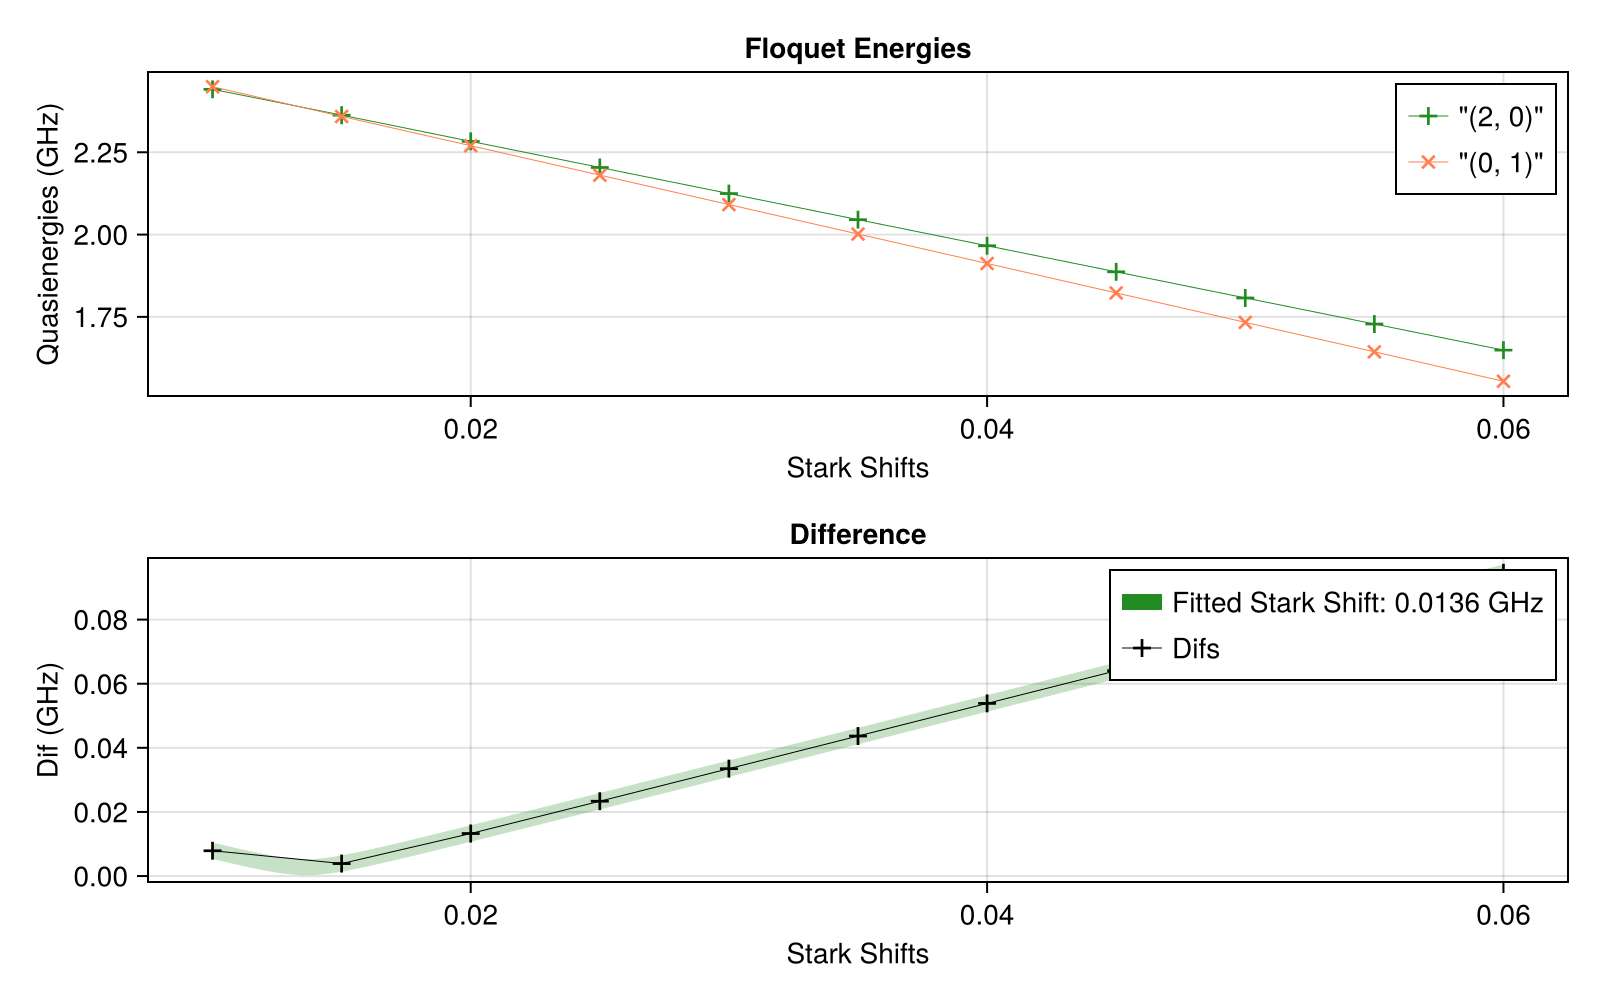

In [16]:
fngnp1_ε = 0.7705
drive_op = Mode6.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode6, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [17]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [18]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][6][1]*1000))

Target flattop time: 355.74776785714283


In [19]:
ψ1 = Mode6.dressed_states[(2,0)]
ψ2 = Mode6.dressed_states[(0,1)]

freq_d = Mode6.dressed_energies[(0,1)]-Mode6.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 18:32:05] Info: On Level 1
[2024-11-10 18:32:05] Info: On Step 1: t = 366.5830544273365
[2024-11-10 18:32:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 18:32:11] Info: Time Evolution Complete
[2024-11-10 18:32:11] Info: Done with Level_1_step_1
[2024-11-10 18:32:11] Info: Accurace: 0.9971519087693035
[2024-11-10 18:32:11] Info: ------------------------------------------------------------------------------
[2024-11-10 18:32:11] Info: On Step 2: t = 372.3959044273365
[2024-11-10 18:32:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 18:32:17] Info: Time Evolution Complete
[2024-11-10 18:32:17] Info: Done with Level_1_step_2
[2024-11-10 18:32:17] Info: Accurace: 0.9991815764997195
[2024-11-10 18:32:17] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 378.935
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>378.935, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999989
  "freq_d"        => -2.1357

In [20]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

355.68396067733653

In [21]:
#Mode6.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 378.935
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>378.935, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999989
  "freq_d"        => -2.1357

In [22]:
ψ = Mode6.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T18:35:55.516
It is being saved at: Data/
[2024-11-10 18:35:55] Info: Running operator sb_f0g1
[2024-11-10 18:35:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-10 18:36:03] Info: Time Evolution Complete
[2024-11-10 18:36:03] Info: Saving Steps
[2024-11-10 18:36:08] Info: Done with Step_1
[2024-11-10 18:36:08] Info: Done With Running Sequence
[2024-11-10 18:36:08] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199966, 0.399932, 0.599898, 0.799864, 0.999829, 1.1998…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [23]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-10 18:36:11] Info: Making Plot


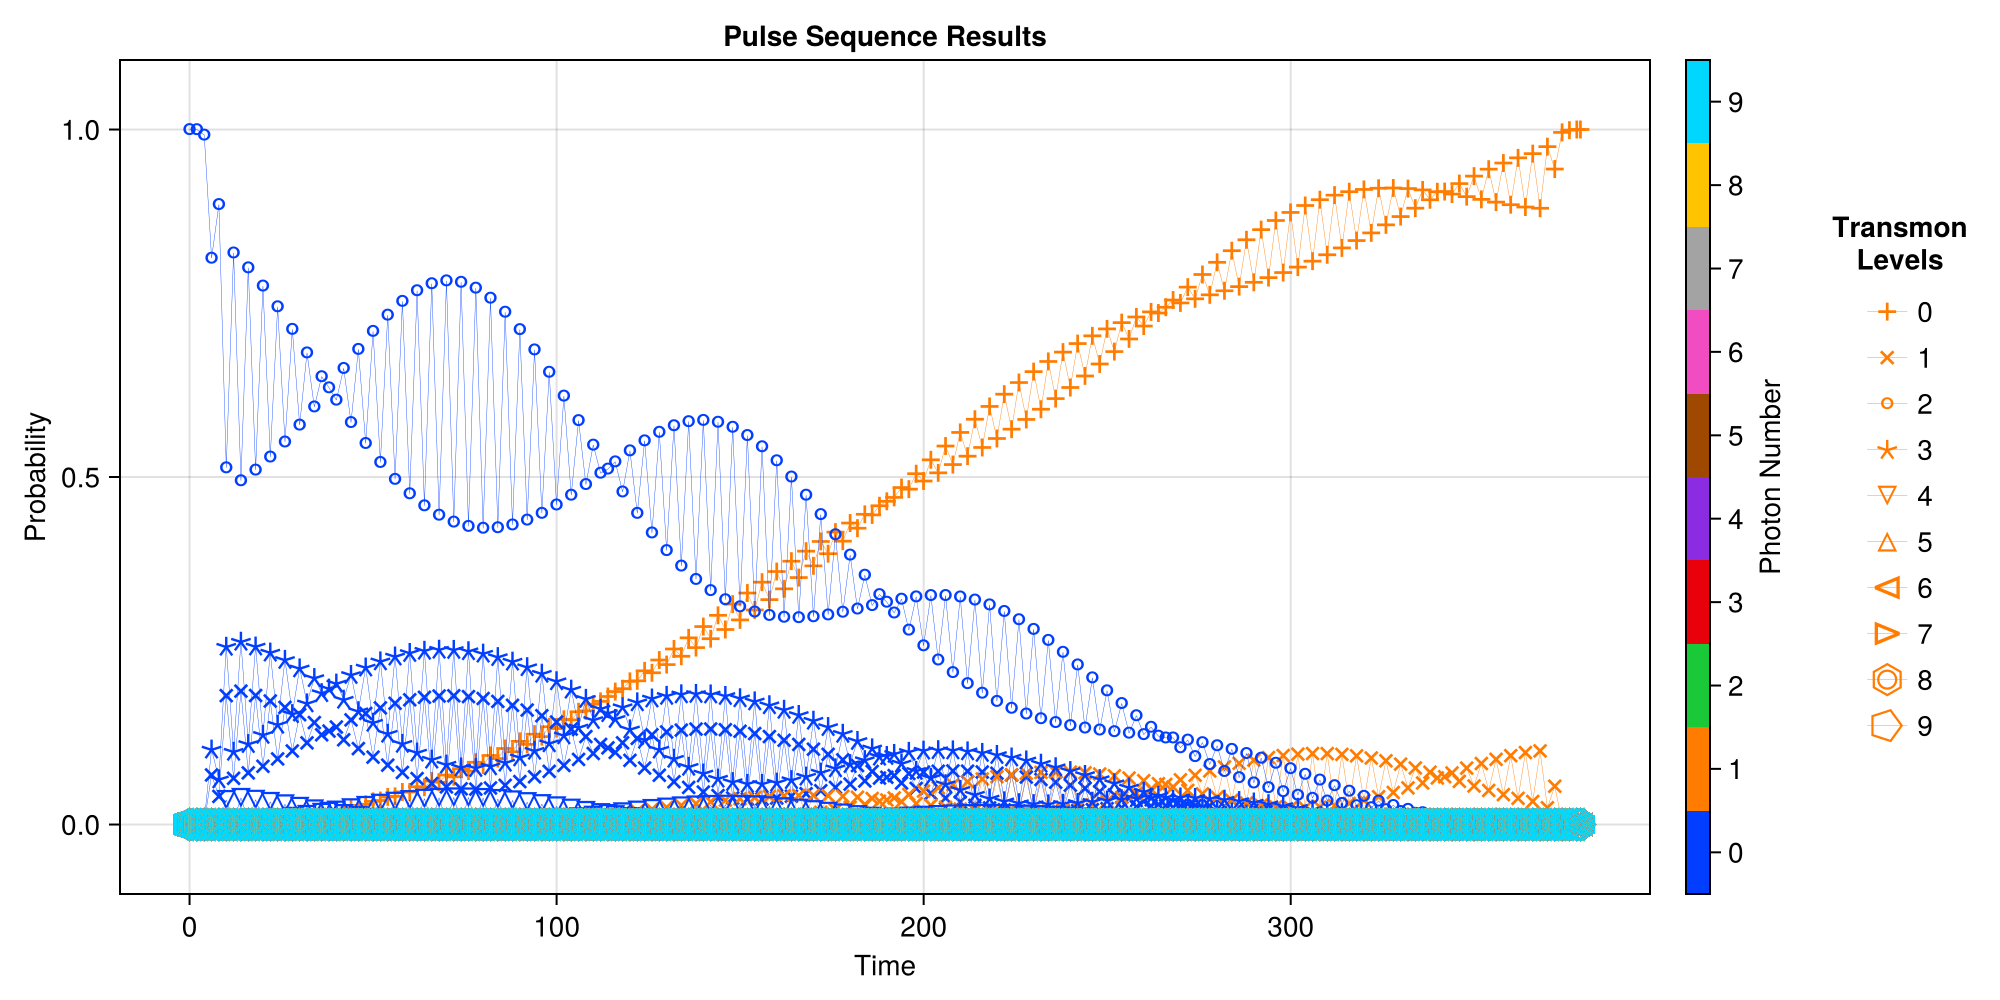

CairoMakie.Screen{IMAGE}


In [24]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [25]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][6][2]*1000))

Target flattop time: 248.79092261904762


In [26]:
ψ1 = Mode6.dressed_states[(2,1)]
ψ2 = Mode6.dressed_states[(0,2)]

freq_d = Mode6.dressed_energies[(0,2)]-Mode6.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 18:36:17] Info: On Level 1
[2024-11-10 18:36:17] Info: On Step 1: t = 259.21336365364687
[2024-11-10 18:36:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 18:36:21] Info: Time Evolution Complete
[2024-11-10 18:36:21] Info: Done with Level_1_step_1
[2024-11-10 18:36:21] Info: Accurace: 0.9943927064286474
[2024-11-10 18:36:21] Info: ------------------------------------------------------------------------------
[2024-11-10 18:36:21] Info: On Step 2: t = 265.0262136536469
[2024-11-10 18:36:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 18:36:28] Info: Time Evolution Complete
[2024-11-10 18:36:28] Info: Done with Level_1_step_2
[2024-11-10 18:36:28] Info: Accurace: 0.9983890446617626
[2024-11-10 18:36:28] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 271.566
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>271.566, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.99994
  "freq_d"        => -2.13541

In [27]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

248.31426990364685

In [28]:
#Mode6.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 271.566
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>271.566, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.99994
  "freq_d"        => -2.13541

### f2->g3

In [29]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][6][3]*1000))

Target flattop time: 202.28794642857142


In [30]:
ψ1 = Mode6.dressed_states[(2,2)]
ψ2 = Mode6.dressed_states[(0,3)]

freq_d = Mode6.dressed_energies[(0,3)]-Mode6.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 18:39:03] Info: On Level 1
[2024-11-10 18:39:03] Info: On Step 1: t = 211.64682515397797
[2024-11-10 18:39:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 18:39:08] Info: Time Evolution Complete
[2024-11-10 18:39:08] Info: Done with Level_1_step_1
[2024-11-10 18:39:08] Info: Accurace: 0.9916102515890389
[2024-11-10 18:39:08] Info: ------------------------------------------------------------------------------
[2024-11-10 18:39:08] Info: On Step 2: t = 217.45967515397797
[2024-11-10 18:39:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 18:39:14] Info: Time Evolution Complete
[2024-11-10 18:39:14] Info: Done with Level_1_step_2
[2024-11-10 18:39:14] Info: Accurace: 0.9975607511453445
[2024-11-10 18:39:14] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 223.999
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>223.999, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999846
  "freq_d"        => -2.13512

In [31]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

200.74773140397798

In [32]:
#Mode6.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 223.999
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>223.999, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999846
  "freq_d"        => -2.13512

### f3->g4

In [33]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][6][4]*1000))

Target flattop time: 172.0610119047619


In [34]:
ψ1 = Mode6.dressed_states[(2,3)]
ψ2 = Mode6.dressed_states[(0,4)]

freq_d = Mode6.dressed_energies[(0,4)]-Mode6.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-10 18:41:16] Info: On Level 1
[2024-11-10 18:41:16] Info: On Step 1: t = 183.29152721366825
[2024-11-10 18:41:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 18:41:20] Info: Time Evolution Complete
[2024-11-10 18:41:20] Info: Done with Level_1_step_1
[2024-11-10 18:41:20] Info: Accurace: 0.9888290356664179
[2024-11-10 18:41:20] Info: ------------------------------------------------------------------------------
[2024-11-10 18:41:20] Info: On Step 2: t = 189.10437721366824
[2024-11-10 18:41:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 18:41:25] Info: Time Evolution Complete
[2024-11-10 18:41:25] Info: Done with Level_1_step_2
[2024-11-10 18:41:25] Info: Accurace: 0.9967262981343965
[2024-11-10 18:41:25] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 195.644
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>195.644, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999743
  "freq_d"        => -2.13483

In [35]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

172.39243346366825

In [36]:
#Mode6.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 195.644
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>195.644, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.7705
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0136308
  "accuracy"      => 0.999743
  "freq_d"        => -2.13483

In [37]:
SC.Utils.save_model(Mode6)

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [38]:
n1 = 1
n2 = 3

freq1 = Mode6.dressed_energies[(2,n1)]-Mode6.dressed_energies[(0,n1+1)]
freq2 = Mode6.dressed_energies[(2,n2)]-Mode6.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.4
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0005799031437305757
m: 1.4142135623730951
n: 1
Required Epsilon: 0.08201068907265746


[2024-11-10 19:52:15] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-10 19:52:26] Info: Done With Floquet Sweep
[2024-11-10 19:52:26] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0001566914888568113	 0.00020644194937166372	 2.0004675111544996


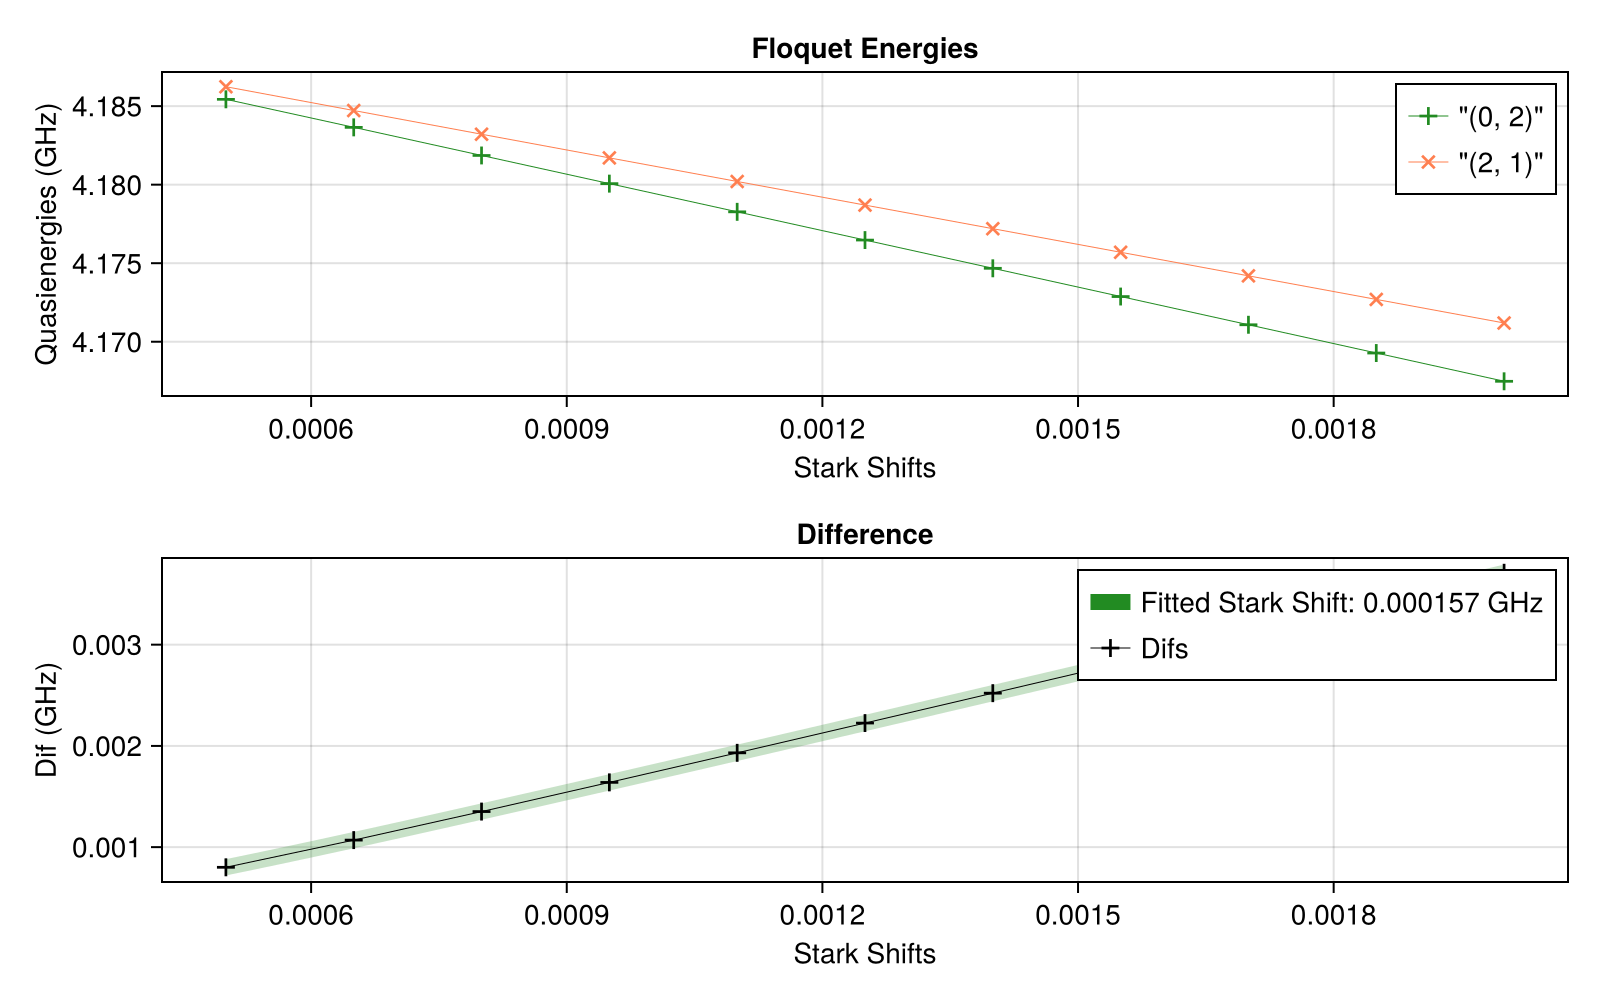

2-element Vector{Float64}:
    0.0001566914888568113
 2421.4223468015716

In [39]:
ε = eps_f1_2pi_g3
drive_op = Mode6.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode6, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [40]:
n2

3

In [ ]:
ψ1 = Mode6.dressed_states[(2,n1)]+Mode6.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode6.dressed_states[(0,n1+1)]+Mode6.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode6.dressed_energies[(0,n1+1)]-Mode6.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode6.dressed_states[(0,n1+1)]*Mode6.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op);

[2024-11-10 19:52:27] Info: On Level 1
[2024-11-10 19:52:27] Info: On Step 1: t = 2397.2081233335557
[2024-11-10 19:52:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-10 19:53:08] Info: Time Evolution Complete
[2024-11-10 19:53:08] Info: Done with Level_1_step_1
[2024-11-10 19:53:08] Info: Using Check Op
[2024-11-10 19:53:08] Info: Accurace: 0.8955377427332583
[2024-11-10 19:53:08] Info: ------------------------------------------------------------------------------
[2024-11-10 19:53:08] Info: On Step 2: t = 2405.2795311562277
[2024-11-10 19:53:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 44s (ETA: 0h 00m 00s)
[2024-11-10 19:53:52] Info: Time Evolution Complete
[2024-11-10 19:53:52] Info: Done with Level_1_step_2
[2024-11-10 19:53:52] Info: Using Check Op
[2024-11-10 19:53:52] Info: Accurace: 0.8962208293192184
[2024-11-10 19:53:52] In

InterruptException: InterruptException:

In [42]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

UndefVarError: UndefVarError: `optimize_res_f1g2_2pi_f3g4` not defined

In [20]:
#Mode6.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 944.706
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>944.706, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0832509
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000761319
  "accuracy"      => 0.999482
  "freq_d"        => -3.10383

In [21]:
ψ = Mode6.dressed_states[(2,1)]+Mode6.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:48:49.463
It is being saved at: Data/
[2024-11-08 18:48:49] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:48:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-08 18:49:30] Info: Time Evolution Complete
[2024-11-08 18:49:30] Info: Saving Steps
[2024-11-08 18:49:37] Info: Done with Step_1
[2024-11-08 18:49:37] Info: Done With Running Sequence
[2024-11-08 18:49:37] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19998, 0.39996, 0.59994, 0.79992, 0.9999, 1.19988, 1.3…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:49:42] Info: Making Plot


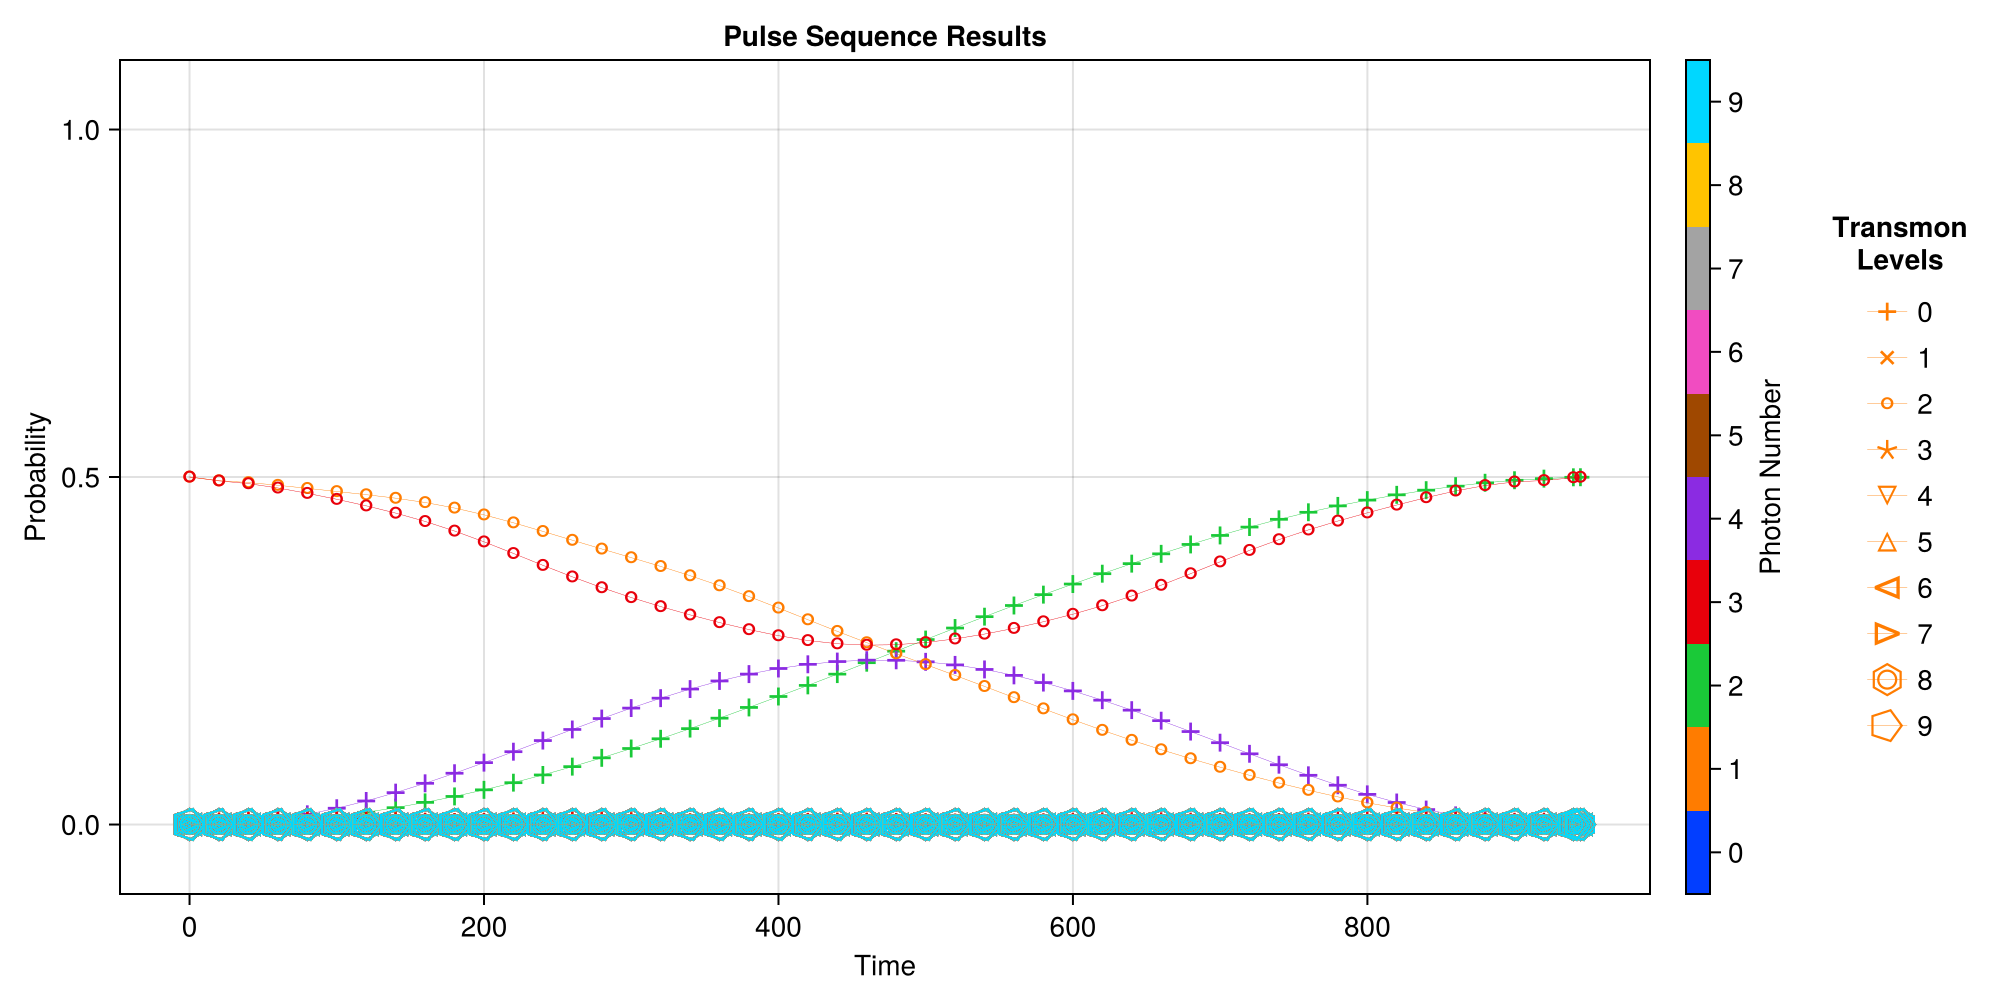

CairoMakie.Screen{IMAGE}


In [23]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [24]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.49979117254934646 + 4.706245818708166e-17im
0.4996905168282355 + 6.065084884910372e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [26]:
n1 = 0
n2 = 3

freq1 = Mode6.dressed_energies[(2,n1)]-Mode6.dressed_energies[(0,n1+1)]
freq2 = Mode6.dressed_energies[(2,n2)]-Mode6.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.001177480925420582
m: 2.0000000000000004
n: 2
Required Epsilon: 0.07647962954143757


[2024-11-08 18:55:07] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-08 18:55:29] Info: Done With Floquet Sweep
[2024-11-08 18:55:29] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006433530530826274	 0.0003423902156711056	 2.002387126418146


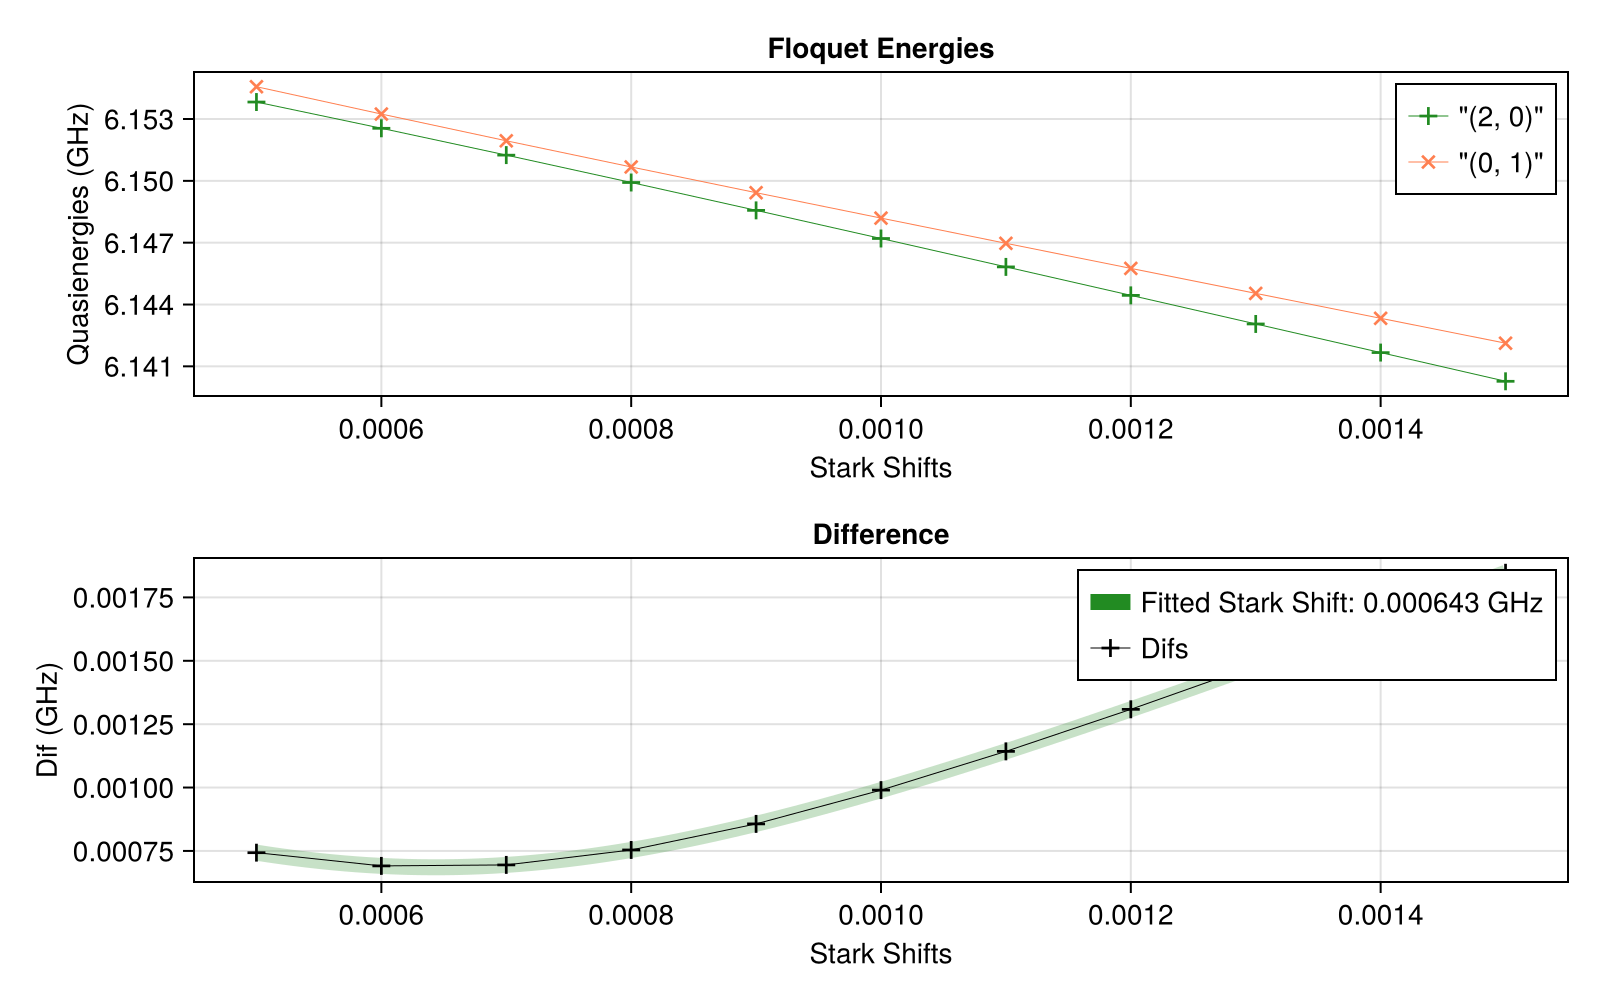

2-element Vector{Float64}:
    0.0006433530530826274
 1458.5811947459163

In [31]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode6.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode6, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [32]:
ψ1 = Mode6.dressed_states[(2,n1)]+Mode6.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode6.dressed_states[(0,n1+1)]+Mode6.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode6.dressed_energies[(0,n1+1)]-Mode6.dressed_energies[(2, n1)]

check_op = 2*Mode6.dressed_states[(0,n1+1)]*Mode6.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-08 18:55:29] Info: On Level 1
[2024-11-08 18:55:29] Info: On Step 1: t = 1458.5811947459163
[2024-11-08 18:55:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:56:41] Info: Time Evolution Complete
[2024-11-08 18:56:41] Info: Done with Level_1_step_1
[2024-11-08 18:56:41] Info: Using Check Op
[2024-11-08 18:56:41] Info: Accurace: 0.9986803501131906
[2024-11-08 18:56:41] Info: ------------------------------------------------------------------------------
[2024-11-08 18:56:41] Info: On Step 2: t = 1481.8325947459164
[2024-11-08 18:56:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:57:57] Info: Time Evolution Complete
[2024-11-08 18:57:57] Info: Done with Level_1_step_2
[2024-11-08 18:57:57] Info: Using Check Op
[2024-11-08 18:57:57] Info: Accurace: 0.999820378239168
[2024-11-08 18:57:57] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [33]:
#Mode6.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [34]:
ψ = Mode6.dressed_states[(2,0)]+Mode6.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T18:58:08.288
It is being saved at: Data/
[2024-11-08 18:58:08] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 18:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 03s (ETA: 0h 00m 00s)
[2024-11-08 18:59:12] Info: Time Evolution Complete
[2024-11-08 18:59:12] Info: Saving Steps
[2024-11-08 18:59:12] Info: Done with Step_1
[2024-11-08 18:59:12] Info: Done With Running Sequence
[2024-11-08 18:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999887, 1.99977, 2.99966, 3.99955, 4.99944, 5.99932, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

In [36]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, res_f0g1_4pi_f3g4["times"], EVs_Dict)

[2024-11-08 18:59:13] Info: Making Plot


CairoMakie.Screen{IMAGE}


In [37]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999974818391036 + 3.209912380096676e-17im
0.4998153296675962 + 8.967827678057819e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [39]:
Mode6.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.67000432799944

In [53]:
starting_args = deepcopy(Mode6.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode6.dressed_states[(2,1)]
ψ2 = Mode6.dressed_states[(2,1)] + Mode6.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode6.dressed_states[(2,1)]*Mode6.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.7]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode6, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 19:02:02] Info: On Level 1
[2024-11-08 19:02:02] Info: On Step 1: t = 74.33500216399972
[2024-11-08 19:02:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:02:07] Info: Time Evolution Complete
[2024-11-08 19:02:07] Info: Done with Level_1_step_1
[2024-11-08 19:02:07] Info: Using Check Op
[2024-11-08 19:02:07] Info: Accurace: 0.9903045931640259
[2024-11-08 19:02:07] Info: ------------------------------------------------------------------------------
[2024-11-08 19:02:07] Info: On Step 2: t = 75.57391886673305
[2024-11-08 19:02:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 19:02:11] Info: Time Evolution Complete
[2024-11-08 19:02:11] Info: Done with Level_1_step_2
[2024-11-08 19:02:11] Info: Using Check Op
[2024-11-08 19:02:11] Info: Accurace: 0.9938610397870073
[2024-11-08 19:02:11] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [54]:
#Mode6.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode6.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [55]:
ψ = Mode6.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode6, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T19:03:32.612
It is being saved at: Data/
[2024-11-08 19:03:32] Info: Running operator sb_half_f1g2
[2024-11-08 19:03:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:03:36] Info: Time Evolution Complete
[2024-11-08 19:03:36] Info: Saving Steps
[2024-11-08 19:03:37] Info: Done with Step_1
[2024-11-08 19:03:37] Info: Done With Running Sequence
[2024-11-08 19:03:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199825, 0.399651, 0.599476, 0.799301, 0.999126, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [56]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 19:03:38] Info: Making Plot


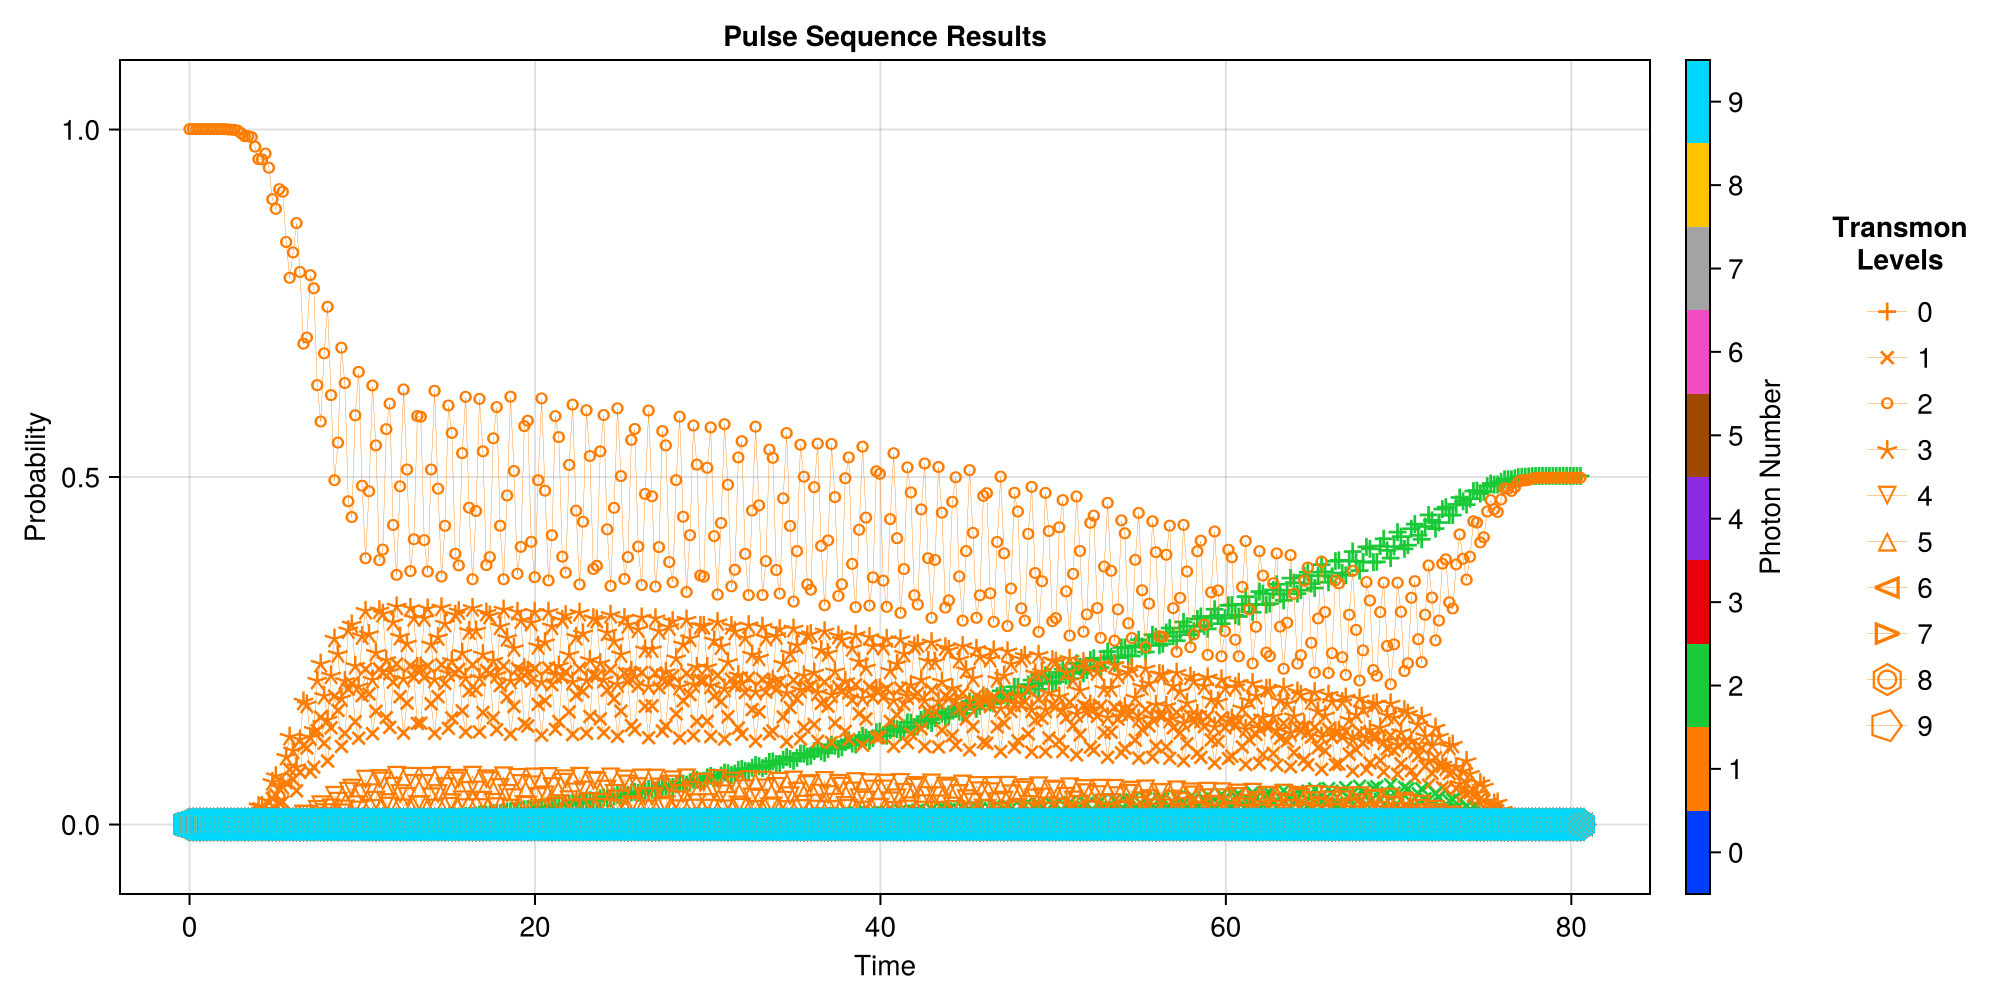

CairoMakie.Screen{IMAGE}


In [57]:
SC.Dynamics.PlotSingleModeEvolution(Mode6, res_half_f1g2["times"], EVs_Dict)

In [58]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49842784624199354 + 3.047257166760866e-18im
0.5015715525412404 - 3.656046931258164e-17im
